<div class="alert alert-block alert-success">

# Plaut Model > plaut_model

### Purpose
Implement the Plaut Model

### Date Created
November 11, 2019
***
#### Revisions
 - For revisions after Jan 02, 2020: refer to the .py files in the same folder
 - The code to run simulation is simply the first code cell. The remaining cells either contain old code or is used for experimentation
 - Jan 02, 2020: Happy New Year! Multiple revisions, see below:
     * Minor bug fixes to folder creation in training
     * Migrate model architecture to model.py
     * Migrate code to import data to simulator.py
     * Migrate code to make folder for storing simulation results to helpers.py
     * Migrate training code to simulator.py
 - Dec 30, 2019: Update filepaths in code to match new file organization
 - Nov 28, 2019: Update training epochs to 500+100, add training for anchors
 - Nov 27, 2019: Move dataset class, helper functions to separate files, Add plotting for accuracy for plaut dataset, anchors and probes
 - Nov 25, 2019: Update get_accuracy function to correspond to sigmoid activated output, Lower print/plot frequency
 - Nov 24, 2019: Replace BCEWithLogitsLoss with BCELoss, and added sigmoid activation to model output
 - Nov 21, 2019: Include correct frequency, fixes to dataset structure
 - Nov 14, 2019: Updates to include frequency
 - Nov 11, 2019: Create file, implement initial Plaut model and train

</div>

### Code to Run Simulation

Test Results will be stored in:  /Users/BrianLam/UTSC Research/Plaut_Model/results/jan09_test01
[EPOCH 1] 	 loss: 0.250835 	 time: 0.7446 
[EPOCH 2] 	 loss: 0.250834 	 time: 0.6284 
[EPOCH 3] 	 loss: 0.250834 	 time: 0.6498 
[EPOCH 4] 	 loss: 0.250833 	 time: 0.6931 
[EPOCH 5] 	 loss: 0.250833 	 time: 0.7871 
[EPOCH 6] 	 loss: 0.250833 	 time: 0.6747 
[EPOCH 7] 	 loss: 0.250832 	 time: 0.7733 
[EPOCH 8] 	 loss: 0.250832 	 time: 0.7496 
[EPOCH 9] 	 loss: 0.250832 	 time: 0.6598 
[EPOCH 10] 	 loss: 0.250831 	 time: 0.8433 
[EPOCH 11] 	 loss: 0.250831 	 time: 1.8254 
[EPOCH 12] 	 loss: 0.239662 	 time: 1.0600 
[EPOCH 13] 	 loss: 0.230577 	 time: 0.9069 
[EPOCH 14] 	 loss: 0.223100 	 time: 0.7503 
[EPOCH 15] 	 loss: 0.216956 	 time: 0.6387 
[EPOCH 16] 	 loss: 0.211961 	 time: 0.6927 
[EPOCH 17] 	 loss: 0.207963 	 time: 0.8169 
[EPOCH 18] 	 loss: 0.204820 	 time: 0.8340 
[EPOCH 19] 	 loss: 0.202387 	 time: 0.6962 
[EPOCH 20] 	 loss: 0.200519 	 time: 0.6958 
[EPOCH 21] 	 loss: 0.199066 	 tim

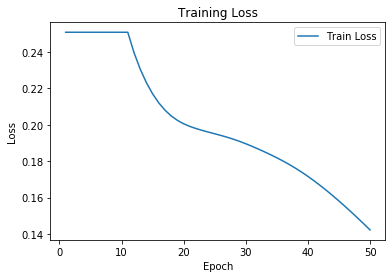

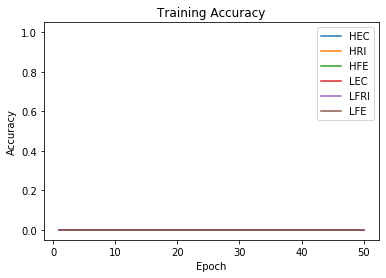

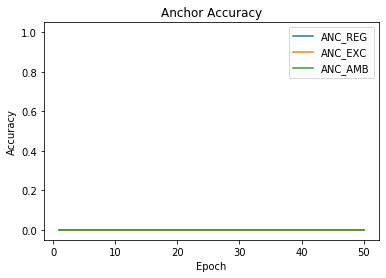

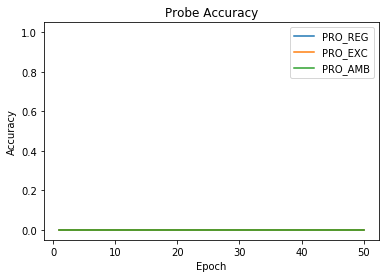

[EPOCH 51] 	 loss: 0.138831 	 time: 0.8040 
[EPOCH 52] 	 loss: 0.135445 	 time: 0.7541 
[EPOCH 53] 	 loss: 0.132037 	 time: 1.0266 
[EPOCH 54] 	 loss: 0.128623 	 time: 0.8943 
[EPOCH 55] 	 loss: 0.125222 	 time: 0.9449 
[EPOCH 56] 	 loss: 0.121852 	 time: 0.7855 
[EPOCH 57] 	 loss: 0.118531 	 time: 0.9299 
[EPOCH 58] 	 loss: 0.115268 	 time: 0.9758 
[EPOCH 59] 	 loss: 0.112067 	 time: 1.1186 
[EPOCH 60] 	 loss: 0.108929 	 time: 2.2860 
[EPOCH 61] 	 loss: 0.105852 	 time: 1.5435 
[EPOCH 62] 	 loss: 0.102840 	 time: 0.9440 
[EPOCH 63] 	 loss: 0.099900 	 time: 0.7767 
[EPOCH 64] 	 loss: 0.097040 	 time: 0.8269 
[EPOCH 65] 	 loss: 0.094268 	 time: 0.8242 
[EPOCH 66] 	 loss: 0.091585 	 time: 1.1409 
[EPOCH 67] 	 loss: 0.088989 	 time: 1.1903 
[EPOCH 68] 	 loss: 0.086480 	 time: 1.1049 
[EPOCH 69] 	 loss: 0.084056 	 time: 0.9913 
[EPOCH 70] 	 loss: 0.081718 	 time: 1.5908 
[EPOCH 71] 	 loss: 0.079467 	 time: 1.3462 
[EPOCH 72] 	 loss: 0.077304 	 time: 1.0868 
[EPOCH 73] 	 loss: 0.075226 	 ti

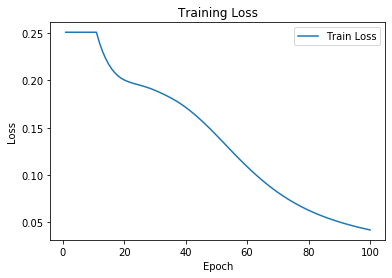

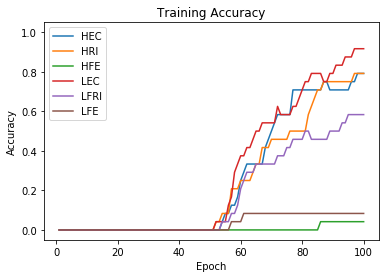

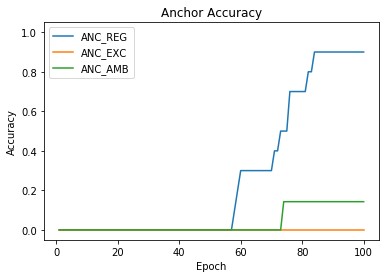

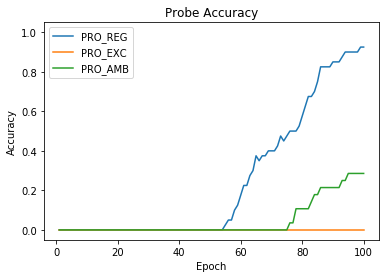

[EPOCH 101] 	 loss: 0.041360 	 time: 0.9790 
[EPOCH 102] 	 loss: 0.040701 	 time: 0.9494 
[EPOCH 103] 	 loss: 0.040063 	 time: 0.9057 
[EPOCH 104] 	 loss: 0.039447 	 time: 1.2723 
[EPOCH 105] 	 loss: 0.038851 	 time: 0.9352 
[EPOCH 106] 	 loss: 0.038273 	 time: 1.0170 
[EPOCH 107] 	 loss: 0.037715 	 time: 1.0907 
[EPOCH 108] 	 loss: 0.037174 	 time: 1.1621 
[EPOCH 109] 	 loss: 0.036651 	 time: 0.9986 
[EPOCH 110] 	 loss: 0.036144 	 time: 0.9826 
[EPOCH 111] 	 loss: 0.035653 	 time: 1.1824 
[EPOCH 112] 	 loss: 0.035178 	 time: 1.2135 
[EPOCH 113] 	 loss: 0.034717 	 time: 1.1813 
[EPOCH 114] 	 loss: 0.034270 	 time: 0.9203 
[EPOCH 115] 	 loss: 0.033837 	 time: 0.9324 
[EPOCH 116] 	 loss: 0.033416 	 time: 0.9397 
[EPOCH 117] 	 loss: 0.033008 	 time: 1.0219 
[EPOCH 118] 	 loss: 0.032611 	 time: 0.9539 
[EPOCH 119] 	 loss: 0.032226 	 time: 1.0117 
[EPOCH 120] 	 loss: 0.031851 	 time: 1.1137 
[EPOCH 121] 	 loss: 0.031487 	 time: 1.1343 
[EPOCH 122] 	 loss: 0.031133 	 time: 1.1856 
[EPOCH 123

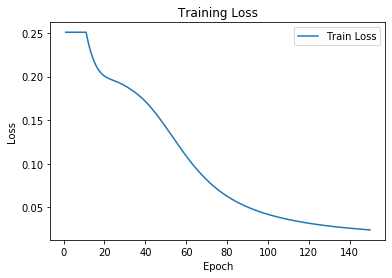

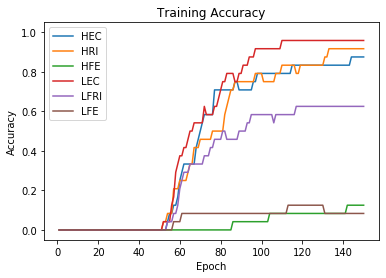

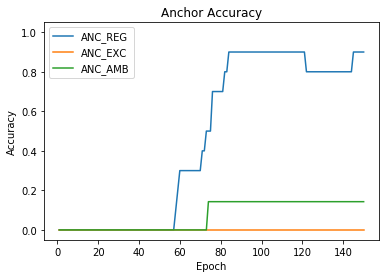

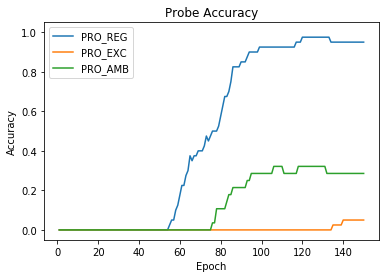

[EPOCH 151] 	 loss: 0.024032 	 time: 1.0268 
[EPOCH 152] 	 loss: 0.023863 	 time: 0.9732 
[EPOCH 153] 	 loss: 0.023697 	 time: 1.0951 
[EPOCH 154] 	 loss: 0.023534 	 time: 0.9711 
[EPOCH 155] 	 loss: 0.023374 	 time: 1.0362 
[EPOCH 156] 	 loss: 0.023218 	 time: 0.9712 
[EPOCH 157] 	 loss: 0.023064 	 time: 1.1036 
[EPOCH 158] 	 loss: 0.022913 	 time: 1.1304 
[EPOCH 159] 	 loss: 0.022765 	 time: 1.0111 
[EPOCH 160] 	 loss: 0.022620 	 time: 1.0023 
[EPOCH 161] 	 loss: 0.022477 	 time: 1.0021 
[EPOCH 162] 	 loss: 0.022336 	 time: 1.1027 
[EPOCH 163] 	 loss: 0.022198 	 time: 1.1269 
[EPOCH 164] 	 loss: 0.022062 	 time: 1.1074 
[EPOCH 165] 	 loss: 0.021929 	 time: 0.9277 
[EPOCH 166] 	 loss: 0.021797 	 time: 1.0294 
[EPOCH 167] 	 loss: 0.021668 	 time: 1.2927 
[EPOCH 168] 	 loss: 0.021540 	 time: 2.1975 
[EPOCH 169] 	 loss: 0.021415 	 time: 1.1787 
[EPOCH 170] 	 loss: 0.021291 	 time: 1.6716 
[EPOCH 171] 	 loss: 0.021169 	 time: 1.9273 
[EPOCH 172] 	 loss: 0.021049 	 time: 1.9347 
[EPOCH 173

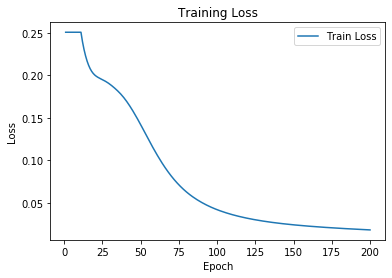

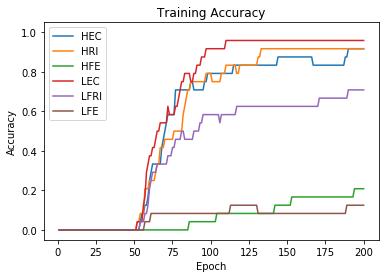

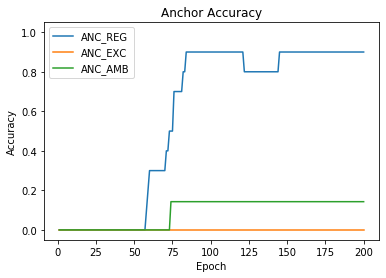

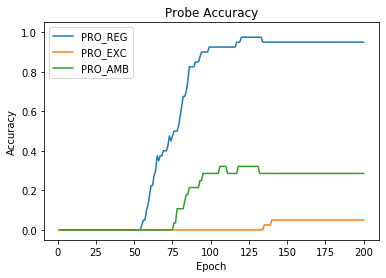

[EPOCH 201] 	 loss: 0.018135 	 time: 1.0938 
[EPOCH 202] 	 loss: 0.018050 	 time: 1.1995 
[EPOCH 203] 	 loss: 0.017965 	 time: 1.1743 
[EPOCH 204] 	 loss: 0.017880 	 time: 1.3985 
[EPOCH 205] 	 loss: 0.017797 	 time: 0.9791 
[EPOCH 206] 	 loss: 0.017714 	 time: 1.0425 
[EPOCH 207] 	 loss: 0.017632 	 time: 1.0475 
[EPOCH 208] 	 loss: 0.017550 	 time: 1.0555 
[EPOCH 209] 	 loss: 0.017470 	 time: 0.9604 
[EPOCH 210] 	 loss: 0.017390 	 time: 1.0623 
[EPOCH 211] 	 loss: 0.017310 	 time: 0.9450 
[EPOCH 212] 	 loss: 0.017231 	 time: 0.9008 
[EPOCH 213] 	 loss: 0.017153 	 time: 0.9676 
[EPOCH 214] 	 loss: 0.017075 	 time: 0.9010 
[EPOCH 215] 	 loss: 0.016998 	 time: 0.9743 
[EPOCH 216] 	 loss: 0.016922 	 time: 0.8913 
[EPOCH 217] 	 loss: 0.016846 	 time: 0.9164 
[EPOCH 218] 	 loss: 0.016770 	 time: 0.9402 
[EPOCH 219] 	 loss: 0.016695 	 time: 1.0268 
[EPOCH 220] 	 loss: 0.016621 	 time: 1.0849 
[EPOCH 221] 	 loss: 0.016547 	 time: 1.1085 
[EPOCH 222] 	 loss: 0.016474 	 time: 1.0688 
[EPOCH 223

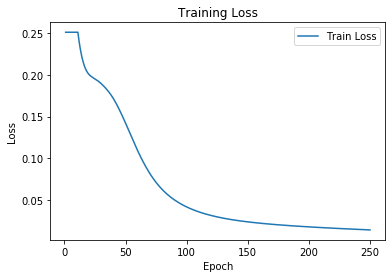

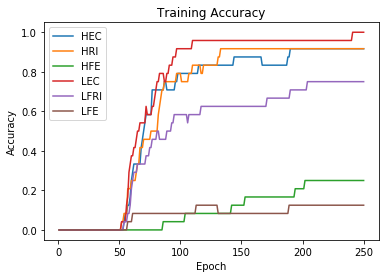

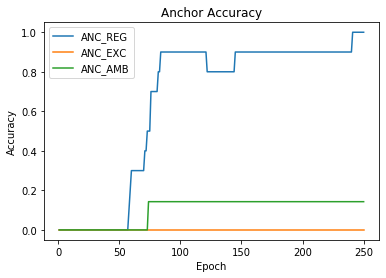

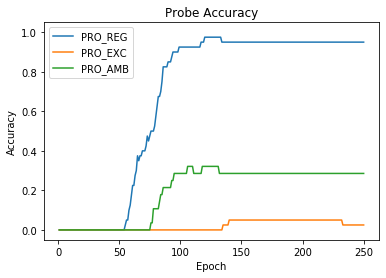

[EPOCH 251] 	 loss: 0.014542 	 time: 1.5025 
[EPOCH 252] 	 loss: 0.014481 	 time: 1.1002 
[EPOCH 253] 	 loss: 0.014420 	 time: 1.3995 
[EPOCH 254] 	 loss: 0.014360 	 time: 1.2793 
[EPOCH 255] 	 loss: 0.014300 	 time: 1.4072 
[EPOCH 256] 	 loss: 0.014240 	 time: 1.1046 
[EPOCH 257] 	 loss: 0.014181 	 time: 1.2327 
[EPOCH 258] 	 loss: 0.014122 	 time: 1.1869 
[EPOCH 259] 	 loss: 0.014063 	 time: 1.0302 
[EPOCH 260] 	 loss: 0.014005 	 time: 1.1444 
[EPOCH 261] 	 loss: 0.013947 	 time: 0.9975 
[EPOCH 262] 	 loss: 0.013889 	 time: 1.2476 
[EPOCH 263] 	 loss: 0.013832 	 time: 1.0812 
[EPOCH 264] 	 loss: 0.013774 	 time: 1.3395 
[EPOCH 265] 	 loss: 0.013717 	 time: 1.0364 
[EPOCH 266] 	 loss: 0.013661 	 time: 1.1757 
[EPOCH 267] 	 loss: 0.013604 	 time: 1.0155 
[EPOCH 268] 	 loss: 0.013548 	 time: 1.3957 
[EPOCH 269] 	 loss: 0.013493 	 time: 1.0248 
[EPOCH 270] 	 loss: 0.013437 	 time: 1.1092 
[EPOCH 271] 	 loss: 0.013382 	 time: 0.9668 
[EPOCH 272] 	 loss: 0.013327 	 time: 1.1350 
[EPOCH 273

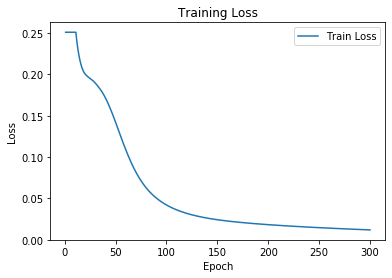

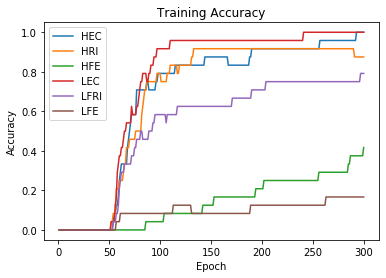

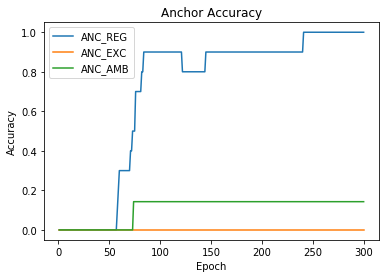

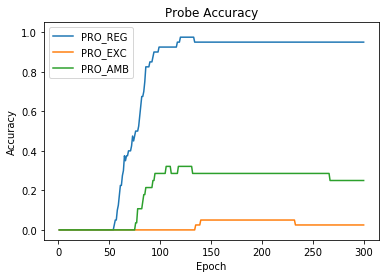

[EPOCH 301] 	 loss: 0.011841 	 time: 1.1455 
[EPOCH 302] 	 loss: 0.011794 	 time: 1.0781 
[EPOCH 303] 	 loss: 0.011746 	 time: 1.0711 
[EPOCH 304] 	 loss: 0.011699 	 time: 1.0125 
[EPOCH 305] 	 loss: 0.011652 	 time: 1.0700 
[EPOCH 306] 	 loss: 0.011605 	 time: 1.0900 
[EPOCH 307] 	 loss: 0.011558 	 time: 0.9774 
[EPOCH 308] 	 loss: 0.011512 	 time: 0.9738 
[EPOCH 309] 	 loss: 0.011466 	 time: 1.1382 
[EPOCH 310] 	 loss: 0.011420 	 time: 1.3102 
[EPOCH 311] 	 loss: 0.011374 	 time: 0.9745 
[EPOCH 312] 	 loss: 0.011328 	 time: 1.0759 
[EPOCH 313] 	 loss: 0.011283 	 time: 1.0549 
[EPOCH 314] 	 loss: 0.011238 	 time: 0.9964 
[EPOCH 315] 	 loss: 0.011193 	 time: 1.1632 
[EPOCH 316] 	 loss: 0.011148 	 time: 1.2104 
[EPOCH 317] 	 loss: 0.011103 	 time: 0.9621 
[EPOCH 318] 	 loss: 0.011059 	 time: 0.9436 
[EPOCH 319] 	 loss: 0.011015 	 time: 1.0646 
[EPOCH 320] 	 loss: 0.010971 	 time: 0.9889 
[EPOCH 321] 	 loss: 0.010927 	 time: 1.0931 
[EPOCH 322] 	 loss: 0.010883 	 time: 0.9731 
[EPOCH 323

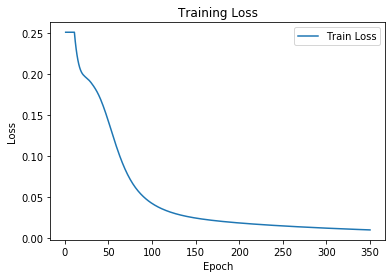

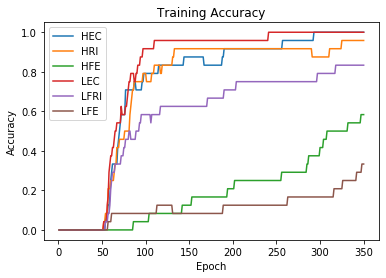

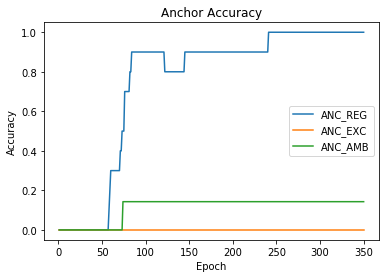

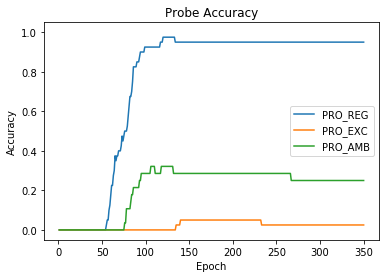

[EPOCH 351] 	 loss: 0.009701 	 time: 1.3876 
[EPOCH 352] 	 loss: 0.009663 	 time: 1.1580 
[EPOCH 353] 	 loss: 0.009625 	 time: 1.5186 
[EPOCH 354] 	 loss: 0.009588 	 time: 1.3149 
[EPOCH 355] 	 loss: 0.009550 	 time: 1.1276 
[EPOCH 356] 	 loss: 0.009513 	 time: 1.2483 
[EPOCH 357] 	 loss: 0.009475 	 time: 1.2360 
[EPOCH 358] 	 loss: 0.009438 	 time: 1.1830 
[EPOCH 359] 	 loss: 0.009401 	 time: 1.0737 
[EPOCH 360] 	 loss: 0.009365 	 time: 1.1359 
[EPOCH 361] 	 loss: 0.009328 	 time: 1.0441 
[EPOCH 362] 	 loss: 0.009292 	 time: 1.1469 
[EPOCH 363] 	 loss: 0.009255 	 time: 1.2728 
[EPOCH 364] 	 loss: 0.009219 	 time: 1.0740 
[EPOCH 365] 	 loss: 0.009183 	 time: 1.1825 
[EPOCH 366] 	 loss: 0.009148 	 time: 1.2157 
[EPOCH 367] 	 loss: 0.009112 	 time: 1.1867 
[EPOCH 368] 	 loss: 0.009077 	 time: 1.0170 
[EPOCH 369] 	 loss: 0.009041 	 time: 0.9360 
[EPOCH 370] 	 loss: 0.009006 	 time: 1.0501 
[EPOCH 371] 	 loss: 0.008971 	 time: 1.0856 
[EPOCH 372] 	 loss: 0.008936 	 time: 1.0288 
[EPOCH 373

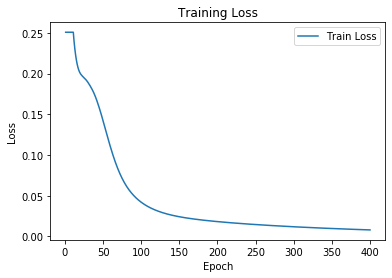

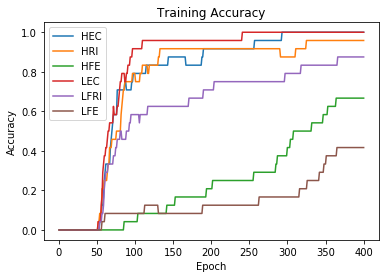

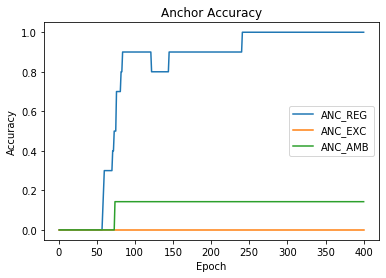

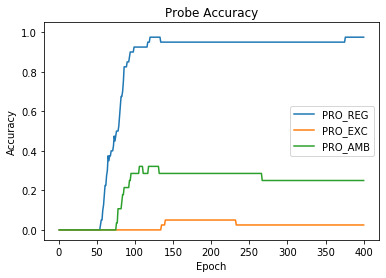

[EPOCH 401] 	 loss: 0.007992 	 time: 1.0051 
[EPOCH 402] 	 loss: 0.007961 	 time: 1.0246 
[EPOCH 403] 	 loss: 0.007931 	 time: 0.9174 
[EPOCH 404] 	 loss: 0.007901 	 time: 1.0395 
[EPOCH 405] 	 loss: 0.007871 	 time: 0.9419 
[EPOCH 406] 	 loss: 0.007841 	 time: 0.9135 
[EPOCH 407] 	 loss: 0.007811 	 time: 0.9225 
[EPOCH 408] 	 loss: 0.007782 	 time: 0.9560 
[EPOCH 409] 	 loss: 0.007752 	 time: 1.0442 
[EPOCH 410] 	 loss: 0.007723 	 time: 0.8811 
[EPOCH 411] 	 loss: 0.007694 	 time: 0.9843 
[EPOCH 412] 	 loss: 0.007665 	 time: 0.9043 
[EPOCH 413] 	 loss: 0.007636 	 time: 0.8899 
[EPOCH 414] 	 loss: 0.007607 	 time: 1.0057 
[EPOCH 415] 	 loss: 0.007578 	 time: 0.8851 
[EPOCH 416] 	 loss: 0.007550 	 time: 0.9916 
[EPOCH 417] 	 loss: 0.007521 	 time: 0.9131 
[EPOCH 418] 	 loss: 0.007493 	 time: 0.9252 
[EPOCH 419] 	 loss: 0.007465 	 time: 0.8543 
[EPOCH 420] 	 loss: 0.007437 	 time: 0.9739 
[EPOCH 421] 	 loss: 0.007409 	 time: 0.8923 
[EPOCH 422] 	 loss: 0.007381 	 time: 0.9179 
[EPOCH 423

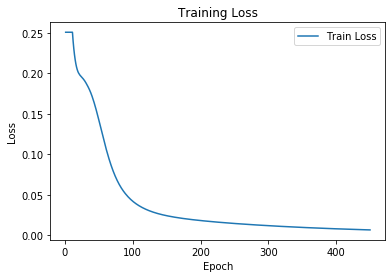

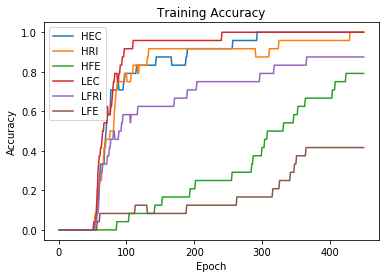

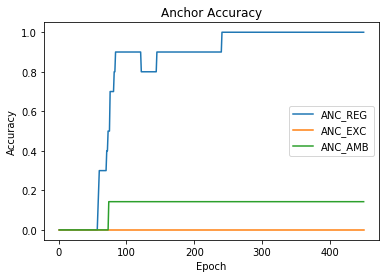

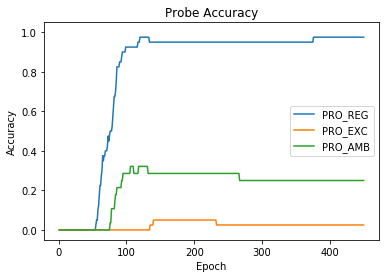

[EPOCH 451] 	 loss: 0.006629 	 time: 0.9655 
[EPOCH 452] 	 loss: 0.006605 	 time: 1.0339 
[EPOCH 453] 	 loss: 0.006581 	 time: 1.0360 
[EPOCH 454] 	 loss: 0.006557 	 time: 1.0339 
[EPOCH 455] 	 loss: 0.006533 	 time: 0.9512 
[EPOCH 456] 	 loss: 0.006510 	 time: 1.1384 
[EPOCH 457] 	 loss: 0.006486 	 time: 0.8763 
[EPOCH 458] 	 loss: 0.006463 	 time: 0.9202 
[EPOCH 459] 	 loss: 0.006439 	 time: 0.8593 
[EPOCH 460] 	 loss: 0.006416 	 time: 0.9369 
[EPOCH 461] 	 loss: 0.006393 	 time: 0.8757 
[EPOCH 462] 	 loss: 0.006370 	 time: 0.9240 
[EPOCH 463] 	 loss: 0.006347 	 time: 0.8502 
[EPOCH 464] 	 loss: 0.006324 	 time: 0.9215 
[EPOCH 465] 	 loss: 0.006301 	 time: 0.9304 
[EPOCH 466] 	 loss: 0.006278 	 time: 1.2857 
[EPOCH 467] 	 loss: 0.006256 	 time: 1.3043 
[EPOCH 468] 	 loss: 0.006233 	 time: 1.1278 
[EPOCH 469] 	 loss: 0.006211 	 time: 1.3238 
[EPOCH 470] 	 loss: 0.006189 	 time: 1.3372 
[EPOCH 471] 	 loss: 0.006167 	 time: 1.3513 
[EPOCH 472] 	 loss: 0.006145 	 time: 1.8440 
[EPOCH 473

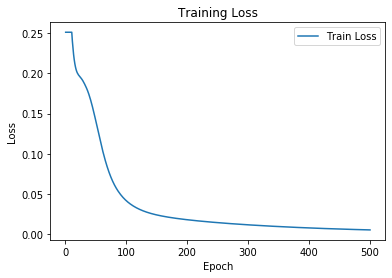

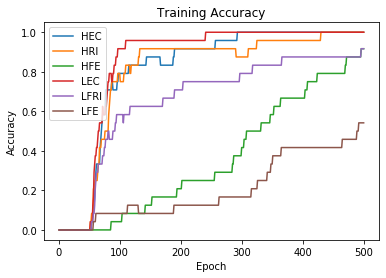

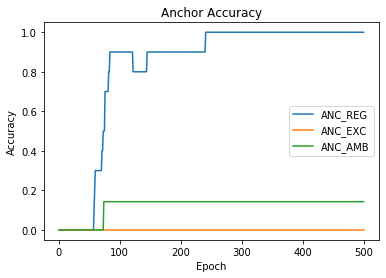

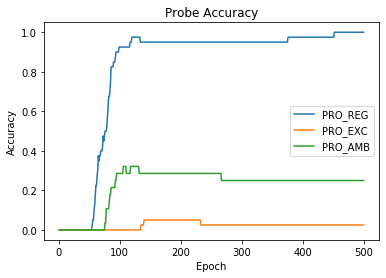

[EPOCH 501] 	 loss: 0.009187 	 time: 1.0808 
[EPOCH 502] 	 loss: 0.009102 	 time: 1.1344 
[EPOCH 503] 	 loss: 0.008979 	 time: 0.9572 
[EPOCH 504] 	 loss: 0.008846 	 time: 1.1135 
[EPOCH 505] 	 loss: 0.008708 	 time: 0.9204 
[EPOCH 506] 	 loss: 0.008563 	 time: 1.0276 
[EPOCH 507] 	 loss: 0.008408 	 time: 0.9719 
[EPOCH 508] 	 loss: 0.008250 	 time: 1.0355 
[EPOCH 509] 	 loss: 0.008101 	 time: 0.9537 
[EPOCH 510] 	 loss: 0.007964 	 time: 0.9953 
[EPOCH 511] 	 loss: 0.007838 	 time: 1.0388 
[EPOCH 512] 	 loss: 0.007719 	 time: 1.1581 
[EPOCH 513] 	 loss: 0.007607 	 time: 1.0574 
[EPOCH 514] 	 loss: 0.007503 	 time: 1.1181 
[EPOCH 515] 	 loss: 0.007406 	 time: 1.0246 
[EPOCH 516] 	 loss: 0.007316 	 time: 0.9038 
[EPOCH 517] 	 loss: 0.007232 	 time: 1.1382 
[EPOCH 518] 	 loss: 0.007156 	 time: 0.9138 
[EPOCH 519] 	 loss: 0.007087 	 time: 1.1458 
[EPOCH 520] 	 loss: 0.007024 	 time: 1.5068 
[EPOCH 521] 	 loss: 0.006964 	 time: 1.0442 
[EPOCH 522] 	 loss: 0.006905 	 time: 0.9524 
[EPOCH 523

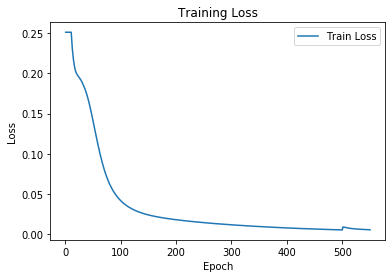

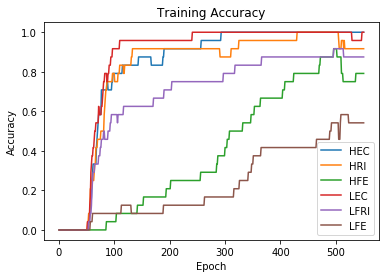

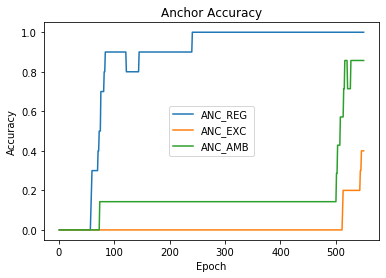

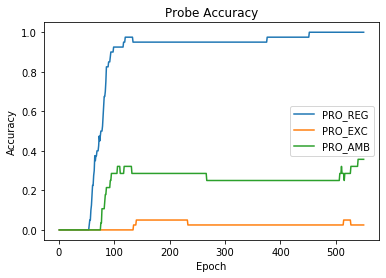

[EPOCH 551] 	 loss: 0.005706 	 time: 0.8854 
[EPOCH 552] 	 loss: 0.005677 	 time: 0.8814 
[EPOCH 553] 	 loss: 0.005649 	 time: 0.9262 
[EPOCH 554] 	 loss: 0.005621 	 time: 0.9197 
[EPOCH 555] 	 loss: 0.005594 	 time: 0.9644 
[EPOCH 556] 	 loss: 0.005567 	 time: 0.9079 
[EPOCH 557] 	 loss: 0.005540 	 time: 0.9525 
[EPOCH 558] 	 loss: 0.005514 	 time: 0.9128 
[EPOCH 559] 	 loss: 0.005488 	 time: 0.9104 
[EPOCH 560] 	 loss: 0.005462 	 time: 1.2377 
[EPOCH 561] 	 loss: 0.005437 	 time: 1.4619 
[EPOCH 562] 	 loss: 0.005412 	 time: 1.1173 
[EPOCH 563] 	 loss: 0.005387 	 time: 1.0797 
[EPOCH 564] 	 loss: 0.005362 	 time: 1.2341 
[EPOCH 565] 	 loss: 0.005338 	 time: 1.0099 
[EPOCH 566] 	 loss: 0.005314 	 time: 1.0048 
[EPOCH 567] 	 loss: 0.005290 	 time: 1.0175 
[EPOCH 568] 	 loss: 0.005267 	 time: 0.9989 
[EPOCH 569] 	 loss: 0.005244 	 time: 1.0305 
[EPOCH 570] 	 loss: 0.005221 	 time: 1.0816 
[EPOCH 571] 	 loss: 0.005198 	 time: 1.0090 
[EPOCH 572] 	 loss: 0.005175 	 time: 0.9515 
[EPOCH 573

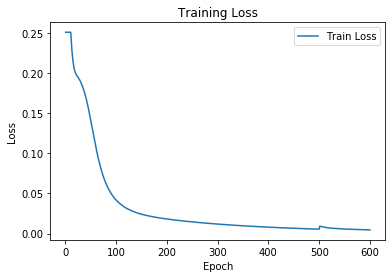

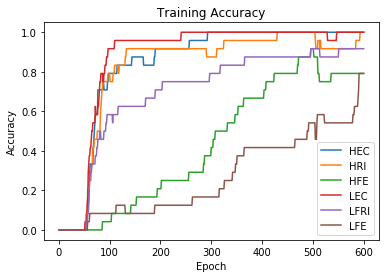

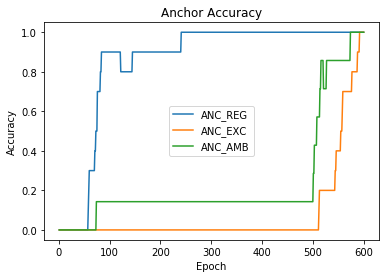

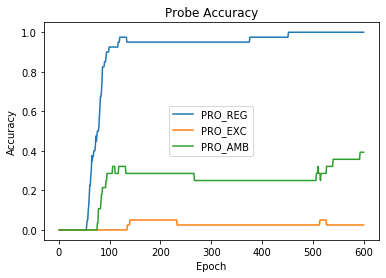

[EPOCH 601] 	 loss: 0.004596 	 time: 1.0334 
[EPOCH 602] 	 loss: 0.004578 	 time: 1.0131 
[EPOCH 603] 	 loss: 0.004560 	 time: 1.0903 
[EPOCH 604] 	 loss: 0.004543 	 time: 1.2985 
[EPOCH 605] 	 loss: 0.004525 	 time: 0.9733 
[EPOCH 606] 	 loss: 0.004508 	 time: 1.0540 
[EPOCH 607] 	 loss: 0.004490 	 time: 0.9676 
[EPOCH 608] 	 loss: 0.004473 	 time: 1.0377 
[EPOCH 609] 	 loss: 0.004456 	 time: 0.9225 
[EPOCH 610] 	 loss: 0.004439 	 time: 0.9904 
[EPOCH 611] 	 loss: 0.004422 	 time: 0.9835 
[EPOCH 612] 	 loss: 0.004405 	 time: 0.9777 
[EPOCH 613] 	 loss: 0.004388 	 time: 1.2269 
[EPOCH 614] 	 loss: 0.004371 	 time: 1.0783 
[EPOCH 615] 	 loss: 0.004355 	 time: 1.1211 
[EPOCH 616] 	 loss: 0.004338 	 time: 0.9473 
[EPOCH 617] 	 loss: 0.004322 	 time: 0.9503 
[EPOCH 618] 	 loss: 0.004306 	 time: 0.8985 
[EPOCH 619] 	 loss: 0.004290 	 time: 1.0270 
[EPOCH 620] 	 loss: 0.004273 	 time: 0.9588 
[EPOCH 621] 	 loss: 0.004257 	 time: 1.0652 
[EPOCH 622] 	 loss: 0.004242 	 time: 1.0887 
[EPOCH 623

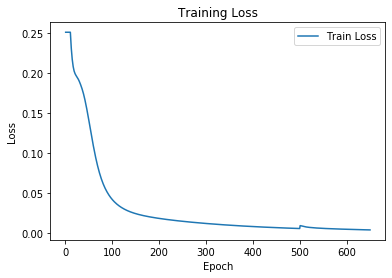

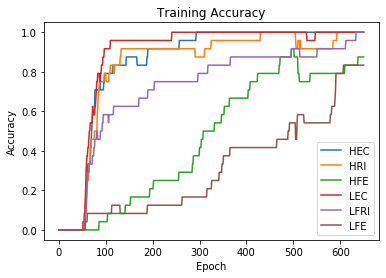

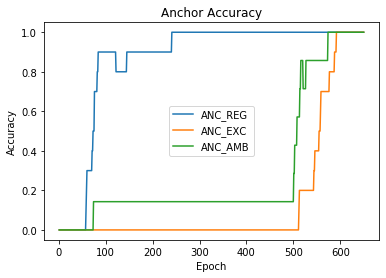

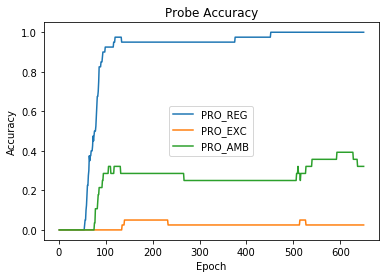

[EPOCH 651] 	 loss: 0.003815 	 time: 0.8610 
[EPOCH 652] 	 loss: 0.003801 	 time: 0.9310 
[EPOCH 653] 	 loss: 0.003788 	 time: 0.8760 
[EPOCH 654] 	 loss: 0.003774 	 time: 0.9158 
[EPOCH 655] 	 loss: 0.003761 	 time: 0.8919 
[EPOCH 656] 	 loss: 0.003748 	 time: 0.9135 
[EPOCH 657] 	 loss: 0.003734 	 time: 0.9362 
[EPOCH 658] 	 loss: 0.003721 	 time: 0.8787 
[EPOCH 659] 	 loss: 0.003708 	 time: 0.9657 
[EPOCH 660] 	 loss: 0.003695 	 time: 0.8738 
[EPOCH 661] 	 loss: 0.003682 	 time: 0.9017 
[EPOCH 662] 	 loss: 0.003669 	 time: 0.9006 
[EPOCH 663] 	 loss: 0.003656 	 time: 0.8767 
[EPOCH 664] 	 loss: 0.003643 	 time: 0.9212 
[EPOCH 665] 	 loss: 0.003631 	 time: 0.8991 
[EPOCH 666] 	 loss: 0.003618 	 time: 0.9606 
[EPOCH 667] 	 loss: 0.003605 	 time: 0.8535 
[EPOCH 668] 	 loss: 0.003593 	 time: 0.9229 
[EPOCH 669] 	 loss: 0.003580 	 time: 0.9454 
[EPOCH 670] 	 loss: 0.003568 	 time: 0.9377 
[EPOCH 671] 	 loss: 0.003556 	 time: 0.8963 
[EPOCH 672] 	 loss: 0.003543 	 time: 0.8618 
[EPOCH 673

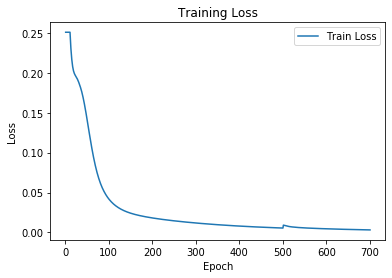

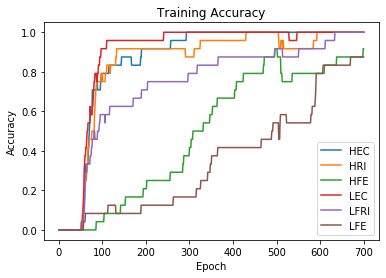

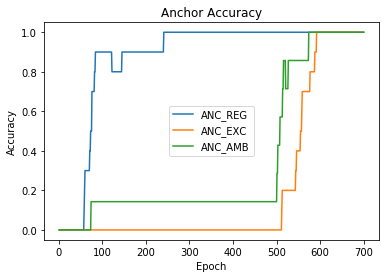

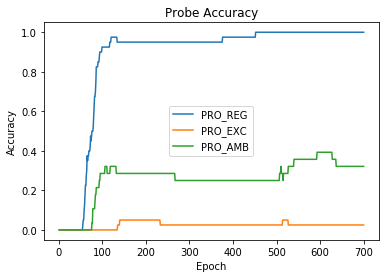

[EPOCH 701] 	 loss: 0.003211 	 time: 0.9132 
[EPOCH 702] 	 loss: 0.003201 	 time: 0.8905 
[EPOCH 703] 	 loss: 0.003190 	 time: 0.9174 
[EPOCH 704] 	 loss: 0.003180 	 time: 0.8811 
[EPOCH 705] 	 loss: 0.003169 	 time: 0.9238 
[EPOCH 706] 	 loss: 0.003159 	 time: 0.8881 
[EPOCH 707] 	 loss: 0.003148 	 time: 0.8849 
[EPOCH 708] 	 loss: 0.003138 	 time: 0.9120 
[EPOCH 709] 	 loss: 0.003128 	 time: 0.8763 
[EPOCH 710] 	 loss: 0.003117 	 time: 0.9032 
[EPOCH 711] 	 loss: 0.003107 	 time: 0.8814 
[EPOCH 712] 	 loss: 0.003097 	 time: 0.9790 
[EPOCH 713] 	 loss: 0.003087 	 time: 0.9135 
[EPOCH 714] 	 loss: 0.003077 	 time: 0.9367 
[EPOCH 715] 	 loss: 0.003067 	 time: 0.8943 
[EPOCH 716] 	 loss: 0.003057 	 time: 0.8946 
[EPOCH 717] 	 loss: 0.003047 	 time: 0.9238 
[EPOCH 718] 	 loss: 0.003037 	 time: 0.8632 
[EPOCH 719] 	 loss: 0.003027 	 time: 0.9398 
[EPOCH 720] 	 loss: 0.003017 	 time: 0.9789 
[EPOCH 721] 	 loss: 0.003008 	 time: 0.9214 
[EPOCH 722] 	 loss: 0.002998 	 time: 0.9059 
[EPOCH 723

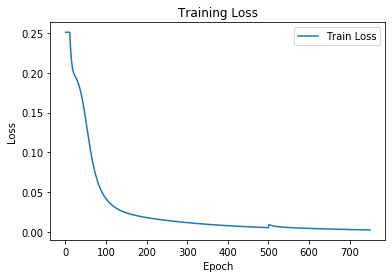

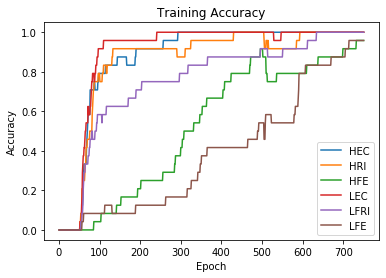

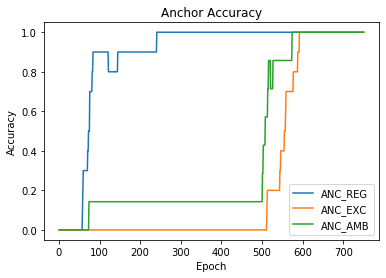

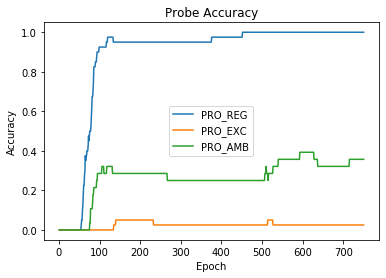

[EPOCH 751] 	 loss: 0.002736 	 time: 0.8797 
[EPOCH 752] 	 loss: 0.002727 	 time: 0.8944 
[EPOCH 753] 	 loss: 0.002719 	 time: 0.8698 
[EPOCH 754] 	 loss: 0.002711 	 time: 1.1222 
[EPOCH 755] 	 loss: 0.002702 	 time: 0.9833 
[EPOCH 756] 	 loss: 0.002694 	 time: 0.9471 
[EPOCH 757] 	 loss: 0.002686 	 time: 0.8409 
[EPOCH 758] 	 loss: 0.002678 	 time: 0.8733 
[EPOCH 759] 	 loss: 0.002669 	 time: 0.8871 
[EPOCH 760] 	 loss: 0.002661 	 time: 0.8747 
[EPOCH 761] 	 loss: 0.002653 	 time: 0.9139 
[EPOCH 762] 	 loss: 0.002645 	 time: 0.8961 
[EPOCH 763] 	 loss: 0.002637 	 time: 1.0445 
[EPOCH 764] 	 loss: 0.002629 	 time: 0.8631 
[EPOCH 765] 	 loss: 0.002621 	 time: 0.9531 
[EPOCH 766] 	 loss: 0.002613 	 time: 0.9614 
[EPOCH 767] 	 loss: 0.002605 	 time: 0.8889 
[EPOCH 768] 	 loss: 0.002598 	 time: 0.9126 
[EPOCH 769] 	 loss: 0.002590 	 time: 0.9103 
[EPOCH 770] 	 loss: 0.002582 	 time: 0.9042 
[EPOCH 771] 	 loss: 0.002574 	 time: 0.8897 
[EPOCH 772] 	 loss: 0.002567 	 time: 0.8889 
[EPOCH 773

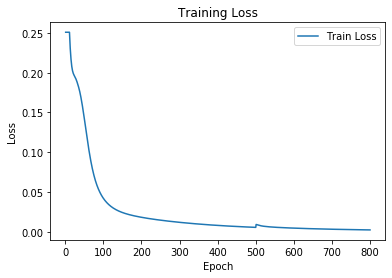

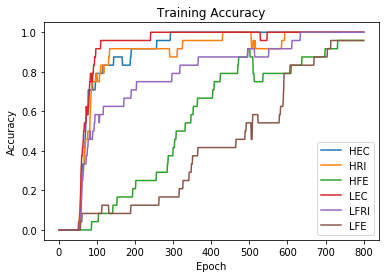

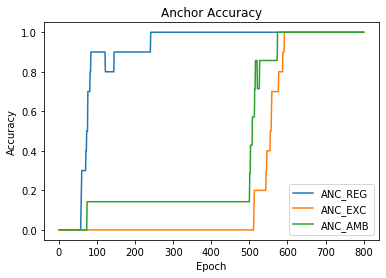

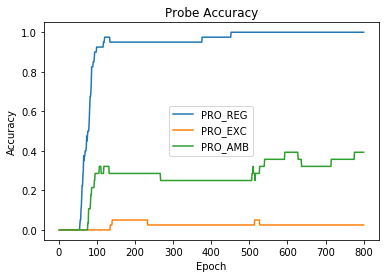

[EPOCH 801] 	 loss: 0.002358 	 time: 0.9336 
[EPOCH 802] 	 loss: 0.002351 	 time: 0.8725 
[EPOCH 803] 	 loss: 0.002344 	 time: 0.9224 
[EPOCH 804] 	 loss: 0.002337 	 time: 0.8595 
[EPOCH 805] 	 loss: 0.002331 	 time: 0.9403 
[EPOCH 806] 	 loss: 0.002324 	 time: 0.8633 
[EPOCH 807] 	 loss: 0.002318 	 time: 0.9182 
[EPOCH 808] 	 loss: 0.002311 	 time: 0.8868 
[EPOCH 809] 	 loss: 0.002305 	 time: 0.9341 
[EPOCH 810] 	 loss: 0.002298 	 time: 0.9499 
[EPOCH 811] 	 loss: 0.002292 	 time: 0.8686 
[EPOCH 812] 	 loss: 0.002285 	 time: 0.9305 
[EPOCH 813] 	 loss: 0.002279 	 time: 0.8738 
[EPOCH 814] 	 loss: 0.002272 	 time: 0.9493 
[EPOCH 815] 	 loss: 0.002266 	 time: 0.8779 
[EPOCH 816] 	 loss: 0.002260 	 time: 0.8994 
[EPOCH 817] 	 loss: 0.002253 	 time: 0.8698 
[EPOCH 818] 	 loss: 0.002247 	 time: 0.8643 
[EPOCH 819] 	 loss: 0.002241 	 time: 0.9185 
[EPOCH 820] 	 loss: 0.002234 	 time: 0.8742 
[EPOCH 821] 	 loss: 0.002228 	 time: 0.9700 
[EPOCH 822] 	 loss: 0.002222 	 time: 0.8999 
[EPOCH 823

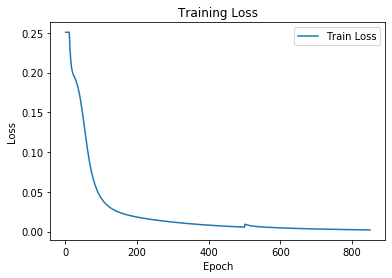

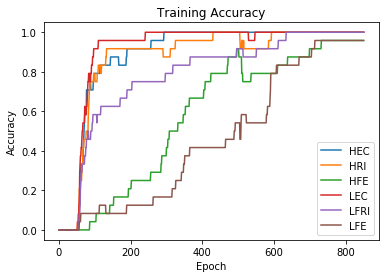

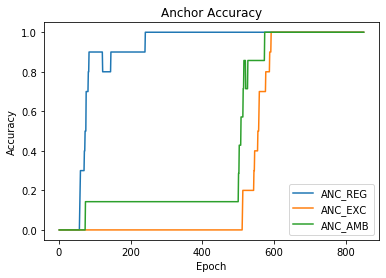

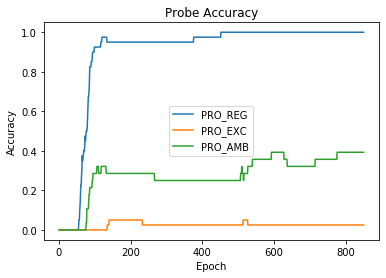

[EPOCH 851] 	 loss: 0.002054 	 time: 0.8737 
[EPOCH 852] 	 loss: 0.002048 	 time: 0.9113 
[EPOCH 853] 	 loss: 0.002043 	 time: 0.8925 
[EPOCH 854] 	 loss: 0.002037 	 time: 1.0260 
[EPOCH 855] 	 loss: 0.002032 	 time: 0.9292 
[EPOCH 856] 	 loss: 0.002027 	 time: 0.9082 
[EPOCH 857] 	 loss: 0.002021 	 time: 0.8986 
[EPOCH 858] 	 loss: 0.002016 	 time: 0.9187 
[EPOCH 859] 	 loss: 0.002011 	 time: 0.9117 
[EPOCH 860] 	 loss: 0.002005 	 time: 0.8888 
[EPOCH 861] 	 loss: 0.002000 	 time: 0.8928 
[EPOCH 862] 	 loss: 0.001995 	 time: 0.8942 
[EPOCH 863] 	 loss: 0.001990 	 time: 0.9304 
[EPOCH 864] 	 loss: 0.001984 	 time: 0.8917 
[EPOCH 865] 	 loss: 0.001979 	 time: 0.9170 
[EPOCH 866] 	 loss: 0.001974 	 time: 0.8766 
[EPOCH 867] 	 loss: 0.001969 	 time: 0.9146 
[EPOCH 868] 	 loss: 0.001964 	 time: 0.8816 
[EPOCH 869] 	 loss: 0.001959 	 time: 0.8727 
[EPOCH 870] 	 loss: 0.001954 	 time: 0.9409 
[EPOCH 871] 	 loss: 0.001949 	 time: 0.8544 
[EPOCH 872] 	 loss: 0.001944 	 time: 0.9087 
[EPOCH 873

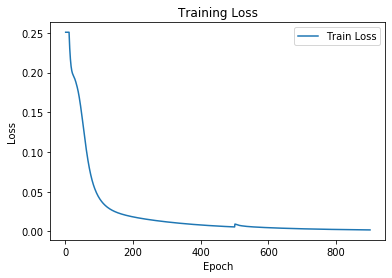

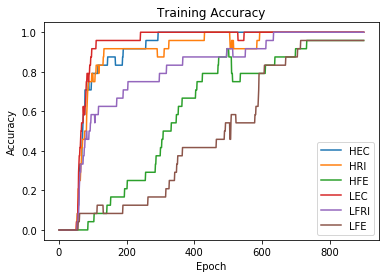

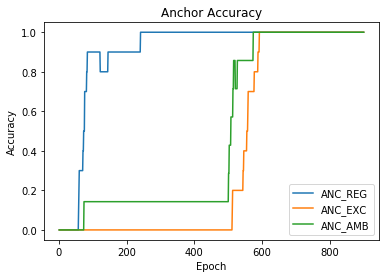

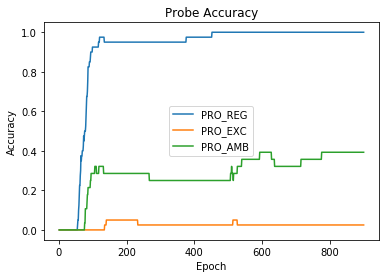

[EPOCH 901] 	 loss: 0.001807 	 time: 0.8734 
[EPOCH 902] 	 loss: 0.001802 	 time: 0.9117 
[EPOCH 903] 	 loss: 0.001798 	 time: 0.9323 
[EPOCH 904] 	 loss: 0.001793 	 time: 0.8967 
[EPOCH 905] 	 loss: 0.001789 	 time: 0.9253 
[EPOCH 906] 	 loss: 0.001784 	 time: 0.8717 
[EPOCH 907] 	 loss: 0.001780 	 time: 0.9375 
[EPOCH 908] 	 loss: 0.001776 	 time: 0.9525 
[EPOCH 909] 	 loss: 0.001771 	 time: 1.0032 
[EPOCH 910] 	 loss: 0.001767 	 time: 0.8900 
[EPOCH 911] 	 loss: 0.001763 	 time: 0.9036 
[EPOCH 912] 	 loss: 0.001759 	 time: 0.9205 
[EPOCH 913] 	 loss: 0.001754 	 time: 0.8863 
[EPOCH 914] 	 loss: 0.001750 	 time: 0.9046 
[EPOCH 915] 	 loss: 0.001746 	 time: 0.8841 
[EPOCH 916] 	 loss: 0.001742 	 time: 0.8812 
[EPOCH 917] 	 loss: 0.001737 	 time: 0.9225 
[EPOCH 918] 	 loss: 0.001733 	 time: 0.9380 
[EPOCH 919] 	 loss: 0.001729 	 time: 1.0451 
[EPOCH 920] 	 loss: 0.001725 	 time: 1.0131 
[EPOCH 921] 	 loss: 0.001721 	 time: 0.8883 
[EPOCH 922] 	 loss: 0.001717 	 time: 0.8493 
[EPOCH 923

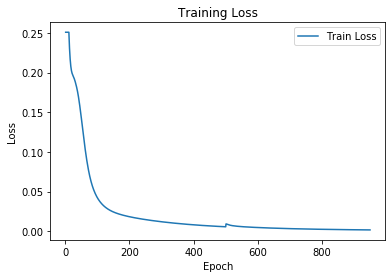

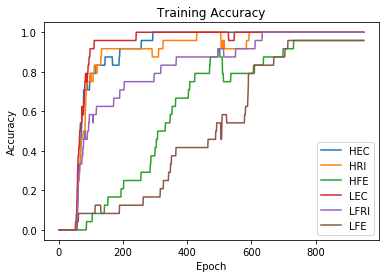

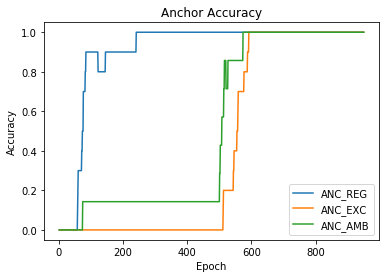

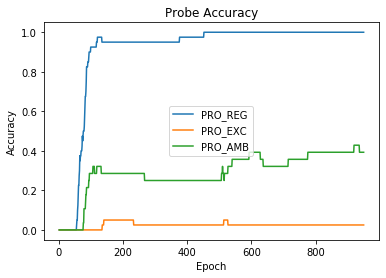

[EPOCH 951] 	 loss: 0.001604 	 time: 0.9205 
[EPOCH 952] 	 loss: 0.001600 	 time: 0.8536 
[EPOCH 953] 	 loss: 0.001597 	 time: 0.8906 
[EPOCH 954] 	 loss: 0.001593 	 time: 0.8969 
[EPOCH 955] 	 loss: 0.001589 	 time: 0.8293 
[EPOCH 956] 	 loss: 0.001586 	 time: 0.9173 
[EPOCH 957] 	 loss: 0.001582 	 time: 0.8650 
[EPOCH 958] 	 loss: 0.001579 	 time: 0.9293 
[EPOCH 959] 	 loss: 0.001575 	 time: 0.8695 
[EPOCH 960] 	 loss: 0.001571 	 time: 1.0243 
[EPOCH 961] 	 loss: 0.001568 	 time: 0.8829 
[EPOCH 962] 	 loss: 0.001564 	 time: 0.8947 
[EPOCH 963] 	 loss: 0.001561 	 time: 0.9333 
[EPOCH 964] 	 loss: 0.001557 	 time: 0.8427 
[EPOCH 965] 	 loss: 0.001554 	 time: 0.9335 
[EPOCH 966] 	 loss: 0.001550 	 time: 0.8955 
[EPOCH 967] 	 loss: 0.001547 	 time: 0.9564 
[EPOCH 968] 	 loss: 0.001543 	 time: 0.8766 
[EPOCH 969] 	 loss: 0.001540 	 time: 0.9254 
[EPOCH 970] 	 loss: 0.001537 	 time: 0.9213 
[EPOCH 971] 	 loss: 0.001533 	 time: 0.8845 
[EPOCH 972] 	 loss: 0.001530 	 time: 0.9388 
[EPOCH 973

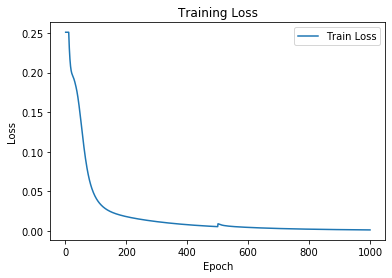

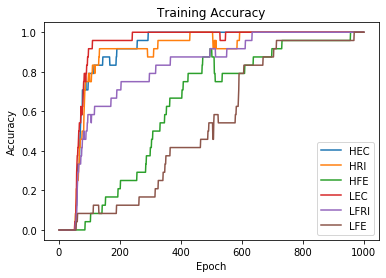

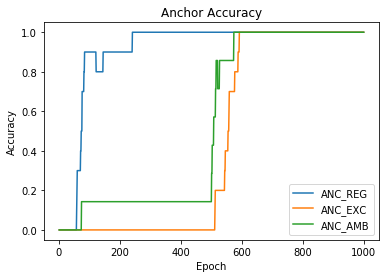

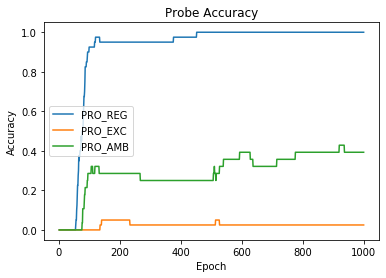

[EPOCH 1001] 	 loss: 0.001436 	 time: 0.8951 
[EPOCH 1002] 	 loss: 0.001433 	 time: 0.9111 
[EPOCH 1003] 	 loss: 0.001430 	 time: 0.8889 
[EPOCH 1004] 	 loss: 0.001427 	 time: 0.9072 
[EPOCH 1005] 	 loss: 0.001424 	 time: 0.8590 
[EPOCH 1006] 	 loss: 0.001421 	 time: 0.8990 
[EPOCH 1007] 	 loss: 0.001418 	 time: 0.9168 
[EPOCH 1008] 	 loss: 0.001415 	 time: 0.8580 
[EPOCH 1009] 	 loss: 0.001412 	 time: 0.9278 
[EPOCH 1010] 	 loss: 0.001409 	 time: 0.8814 
[EPOCH 1011] 	 loss: 0.001406 	 time: 1.0793 
[EPOCH 1012] 	 loss: 0.001403 	 time: 0.9477 
[EPOCH 1013] 	 loss: 0.001400 	 time: 0.8609 
[EPOCH 1014] 	 loss: 0.001398 	 time: 1.0278 
[EPOCH 1015] 	 loss: 0.001395 	 time: 0.8758 
[EPOCH 1016] 	 loss: 0.001392 	 time: 0.9467 
[EPOCH 1017] 	 loss: 0.001389 	 time: 0.8809 
[EPOCH 1018] 	 loss: 0.001386 	 time: 0.9076 
[EPOCH 1019] 	 loss: 0.001383 	 time: 0.8688 
[EPOCH 1020] 	 loss: 0.001380 	 time: 1.0402 
[EPOCH 1021] 	 loss: 0.001377 	 time: 0.9148 
[EPOCH 1022] 	 loss: 0.001375 	 ti

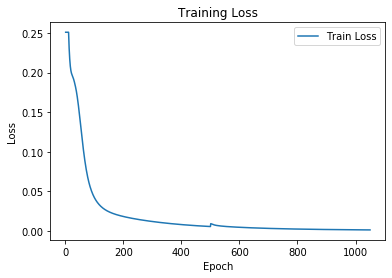

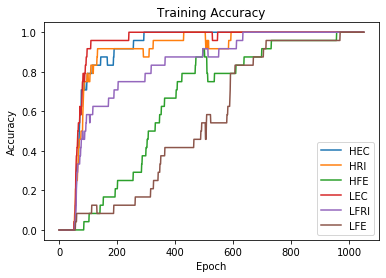

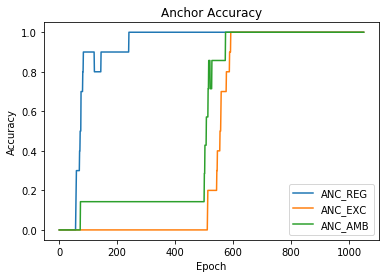

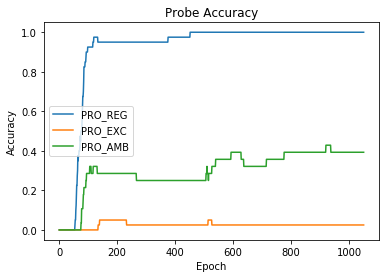

[EPOCH 1051] 	 loss: 0.001296 	 time: 0.9116 
[EPOCH 1052] 	 loss: 0.001294 	 time: 0.9022 
[EPOCH 1053] 	 loss: 0.001291 	 time: 0.8950 
[EPOCH 1054] 	 loss: 0.001289 	 time: 0.8860 
[EPOCH 1055] 	 loss: 0.001286 	 time: 0.9903 
[EPOCH 1056] 	 loss: 0.001284 	 time: 0.8643 
[EPOCH 1057] 	 loss: 0.001281 	 time: 0.8780 
[EPOCH 1058] 	 loss: 0.001279 	 time: 0.9138 
[EPOCH 1059] 	 loss: 0.001276 	 time: 0.8808 
[EPOCH 1060] 	 loss: 0.001274 	 time: 0.9114 
[EPOCH 1061] 	 loss: 0.001271 	 time: 0.8956 
[EPOCH 1062] 	 loss: 0.001269 	 time: 0.9032 
[EPOCH 1063] 	 loss: 0.001266 	 time: 0.8779 
[EPOCH 1064] 	 loss: 0.001264 	 time: 0.9172 
[EPOCH 1065] 	 loss: 0.001261 	 time: 0.9094 
[EPOCH 1066] 	 loss: 0.001259 	 time: 0.8699 
[EPOCH 1067] 	 loss: 0.001256 	 time: 0.9286 
[EPOCH 1068] 	 loss: 0.001254 	 time: 0.8969 
[EPOCH 1069] 	 loss: 0.001252 	 time: 0.9016 
[EPOCH 1070] 	 loss: 0.001249 	 time: 0.8619 
[EPOCH 1071] 	 loss: 0.001247 	 time: 0.8955 
[EPOCH 1072] 	 loss: 0.001244 	 ti

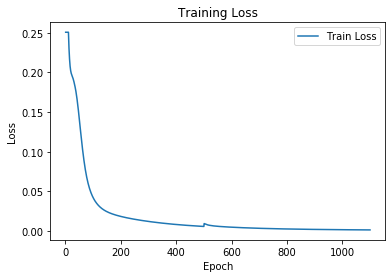

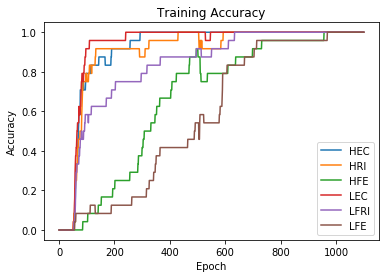

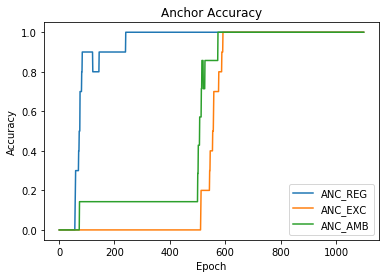

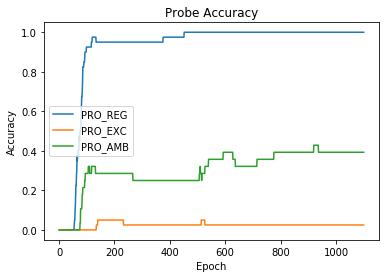

[EPOCH 1101] 	 loss: 0.001178 	 time: 0.8680 
[EPOCH 1102] 	 loss: 0.001176 	 time: 0.9292 
[EPOCH 1103] 	 loss: 0.001174 	 time: 0.8513 
[EPOCH 1104] 	 loss: 0.001172 	 time: 0.9372 
[EPOCH 1105] 	 loss: 0.001170 	 time: 0.8855 
[EPOCH 1106] 	 loss: 0.001168 	 time: 0.9277 
[EPOCH 1107] 	 loss: 0.001166 	 time: 0.8666 
[EPOCH 1108] 	 loss: 0.001163 	 time: 0.8612 
[EPOCH 1109] 	 loss: 0.001161 	 time: 0.9237 
[EPOCH 1110] 	 loss: 0.001159 	 time: 0.8674 
[EPOCH 1111] 	 loss: 0.001157 	 time: 0.9103 
[EPOCH 1112] 	 loss: 0.001155 	 time: 0.8904 
[EPOCH 1113] 	 loss: 0.001153 	 time: 0.9423 
[EPOCH 1114] 	 loss: 0.001151 	 time: 0.8665 
[EPOCH 1115] 	 loss: 0.001149 	 time: 0.9084 
[EPOCH 1116] 	 loss: 0.001147 	 time: 0.8642 
[EPOCH 1117] 	 loss: 0.001145 	 time: 0.9029 
[EPOCH 1118] 	 loss: 0.001143 	 time: 0.9187 
[EPOCH 1119] 	 loss: 0.001141 	 time: 0.8438 
[EPOCH 1120] 	 loss: 0.001139 	 time: 0.9290 
[EPOCH 1121] 	 loss: 0.001137 	 time: 0.8313 
[EPOCH 1122] 	 loss: 0.001135 	 ti

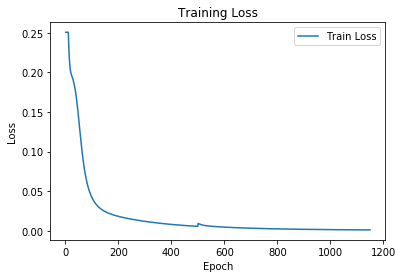

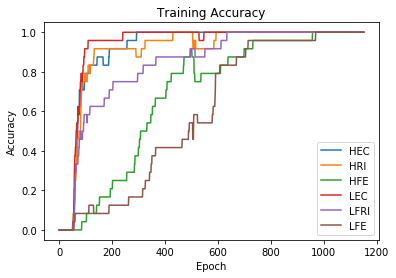

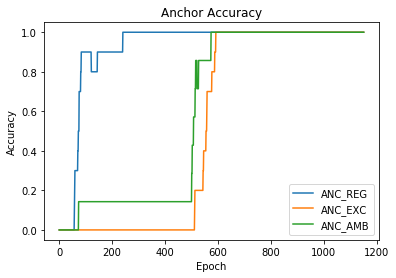

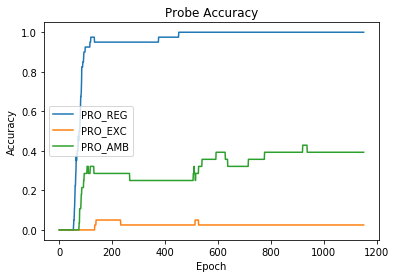

[EPOCH 1151] 	 loss: 0.001078 	 time: 0.9301 
[EPOCH 1152] 	 loss: 0.001077 	 time: 0.8761 
[EPOCH 1153] 	 loss: 0.001075 	 time: 0.9329 
[EPOCH 1154] 	 loss: 0.001073 	 time: 0.8682 
[EPOCH 1155] 	 loss: 0.001071 	 time: 0.8950 
[EPOCH 1156] 	 loss: 0.001069 	 time: 0.8689 
[EPOCH 1157] 	 loss: 0.001067 	 time: 0.9183 
[EPOCH 1158] 	 loss: 0.001066 	 time: 0.8526 
[EPOCH 1159] 	 loss: 0.001064 	 time: 0.8520 
[EPOCH 1160] 	 loss: 0.001062 	 time: 1.0257 
[EPOCH 1161] 	 loss: 0.001060 	 time: 0.8830 
[EPOCH 1162] 	 loss: 0.001058 	 time: 0.9202 
[EPOCH 1163] 	 loss: 0.001057 	 time: 0.8782 
[EPOCH 1164] 	 loss: 0.001055 	 time: 0.9048 
[EPOCH 1165] 	 loss: 0.001053 	 time: 0.8694 
[EPOCH 1166] 	 loss: 0.001051 	 time: 0.9099 
[EPOCH 1167] 	 loss: 0.001050 	 time: 0.8861 
[EPOCH 1168] 	 loss: 0.001048 	 time: 0.8586 
[EPOCH 1169] 	 loss: 0.001046 	 time: 0.9323 
[EPOCH 1170] 	 loss: 0.001044 	 time: 0.8797 
[EPOCH 1171] 	 loss: 0.001043 	 time: 0.9409 
[EPOCH 1172] 	 loss: 0.001041 	 ti

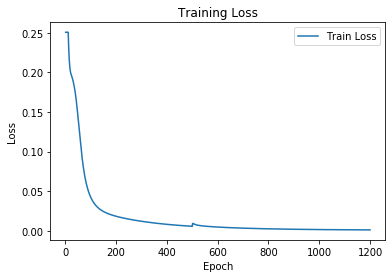

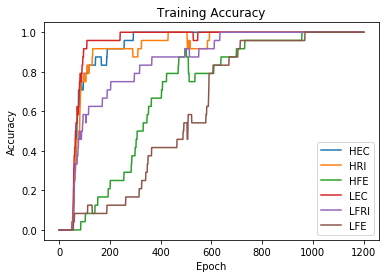

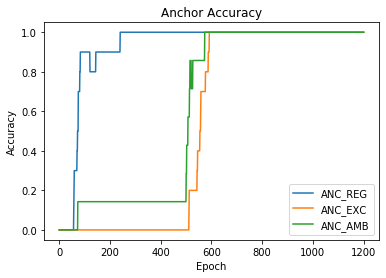

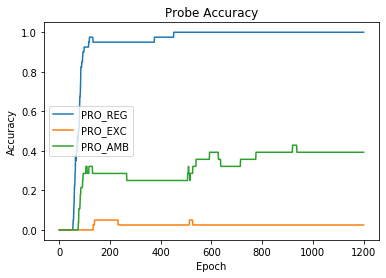

[EPOCH 1201] 	 loss: 0.000993 	 time: 0.8779 
[EPOCH 1202] 	 loss: 0.000991 	 time: 0.8877 
[EPOCH 1203] 	 loss: 0.000990 	 time: 0.8773 
[EPOCH 1204] 	 loss: 0.000988 	 time: 0.9012 
[EPOCH 1205] 	 loss: 0.000987 	 time: 0.8770 
[EPOCH 1206] 	 loss: 0.000985 	 time: 0.9161 
[EPOCH 1207] 	 loss: 0.000983 	 time: 0.9368 
[EPOCH 1208] 	 loss: 0.000982 	 time: 0.9314 
[EPOCH 1209] 	 loss: 0.000980 	 time: 0.8447 
[EPOCH 1210] 	 loss: 0.000979 	 time: 0.8738 
[EPOCH 1211] 	 loss: 0.000977 	 time: 0.9134 
[EPOCH 1212] 	 loss: 0.000976 	 time: 0.9073 
[EPOCH 1213] 	 loss: 0.000974 	 time: 0.9031 
[EPOCH 1214] 	 loss: 0.000973 	 time: 0.8601 
[EPOCH 1215] 	 loss: 0.000971 	 time: 0.9054 
[EPOCH 1216] 	 loss: 0.000970 	 time: 0.8714 
[EPOCH 1217] 	 loss: 0.000968 	 time: 0.9241 
[EPOCH 1218] 	 loss: 0.000967 	 time: 0.8769 
[EPOCH 1219] 	 loss: 0.000965 	 time: 0.8818 
[EPOCH 1220] 	 loss: 0.000964 	 time: 0.9141 
[EPOCH 1221] 	 loss: 0.000962 	 time: 0.8799 
[EPOCH 1222] 	 loss: 0.000961 	 ti

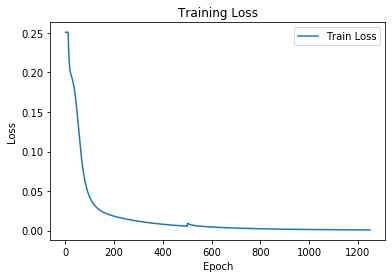

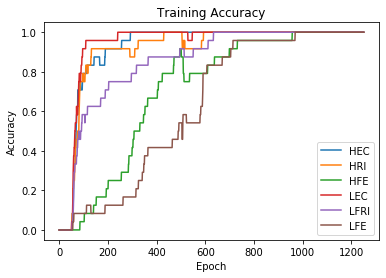

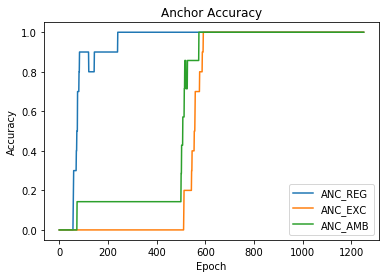

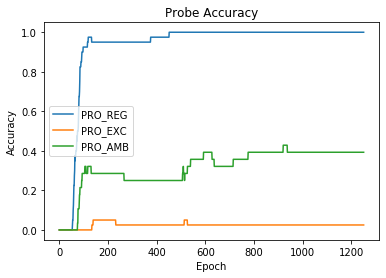

[EPOCH 1251] 	 loss: 0.000919 	 time: 0.8338 
[EPOCH 1252] 	 loss: 0.000918 	 time: 0.8717 
[EPOCH 1253] 	 loss: 0.000916 	 time: 0.9347 
[EPOCH 1254] 	 loss: 0.000915 	 time: 0.8804 
[EPOCH 1255] 	 loss: 0.000914 	 time: 0.9491 
[EPOCH 1256] 	 loss: 0.000912 	 time: 0.9564 
[EPOCH 1257] 	 loss: 0.000911 	 time: 0.9580 
[EPOCH 1258] 	 loss: 0.000910 	 time: 0.8517 
[EPOCH 1259] 	 loss: 0.000908 	 time: 0.9268 
[EPOCH 1260] 	 loss: 0.000907 	 time: 0.8670 
[EPOCH 1261] 	 loss: 0.000906 	 time: 0.8960 
[EPOCH 1262] 	 loss: 0.000904 	 time: 0.9045 
[EPOCH 1263] 	 loss: 0.000903 	 time: 0.8669 
[EPOCH 1264] 	 loss: 0.000902 	 time: 0.9126 
[EPOCH 1265] 	 loss: 0.000900 	 time: 0.8960 
[EPOCH 1266] 	 loss: 0.000899 	 time: 0.9273 
[EPOCH 1267] 	 loss: 0.000898 	 time: 0.8731 
[EPOCH 1268] 	 loss: 0.000896 	 time: 0.9164 
[EPOCH 1269] 	 loss: 0.000895 	 time: 0.8542 
[EPOCH 1270] 	 loss: 0.000894 	 time: 1.0664 
[EPOCH 1271] 	 loss: 0.000893 	 time: 0.8708 
[EPOCH 1272] 	 loss: 0.000891 	 ti

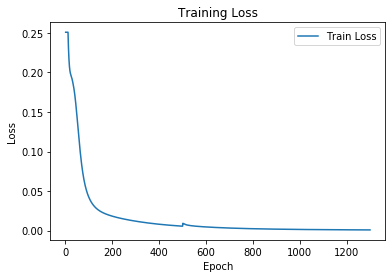

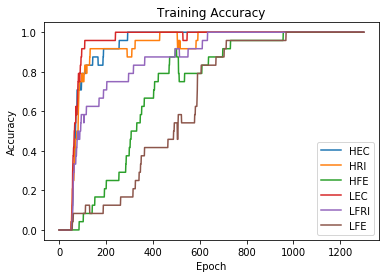

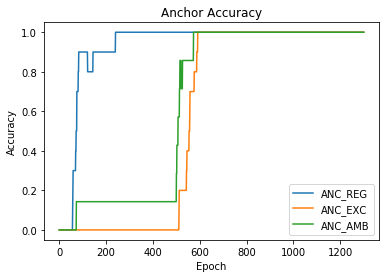

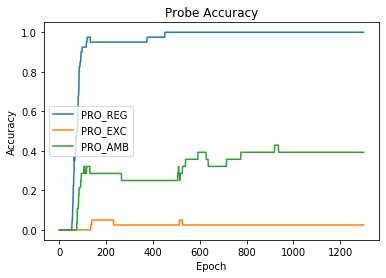

[EPOCH 1301] 	 loss: 0.000855 	 time: 0.9232 
[EPOCH 1302] 	 loss: 0.000854 	 time: 0.8785 
[EPOCH 1303] 	 loss: 0.000853 	 time: 0.8778 
[EPOCH 1304] 	 loss: 0.000852 	 time: 0.9452 
[EPOCH 1305] 	 loss: 0.000851 	 time: 0.8616 
[EPOCH 1306] 	 loss: 0.000849 	 time: 0.9717 
[EPOCH 1307] 	 loss: 0.000848 	 time: 0.8886 
[EPOCH 1308] 	 loss: 0.000847 	 time: 0.9154 
[EPOCH 1309] 	 loss: 0.000846 	 time: 0.8824 
[EPOCH 1310] 	 loss: 0.000845 	 time: 0.9099 
[EPOCH 1311] 	 loss: 0.000844 	 time: 0.9037 
[EPOCH 1312] 	 loss: 0.000842 	 time: 0.8737 
[EPOCH 1313] 	 loss: 0.000841 	 time: 0.9224 
[EPOCH 1314] 	 loss: 0.000840 	 time: 0.9960 
[EPOCH 1315] 	 loss: 0.000839 	 time: 0.9768 
[EPOCH 1316] 	 loss: 0.000838 	 time: 0.8903 
[EPOCH 1317] 	 loss: 0.000837 	 time: 0.9309 
[EPOCH 1318] 	 loss: 0.000835 	 time: 0.8826 
[EPOCH 1319] 	 loss: 0.000834 	 time: 0.9298 
[EPOCH 1320] 	 loss: 0.000833 	 time: 0.8526 
[EPOCH 1321] 	 loss: 0.000832 	 time: 0.8487 
[EPOCH 1322] 	 loss: 0.000831 	 ti

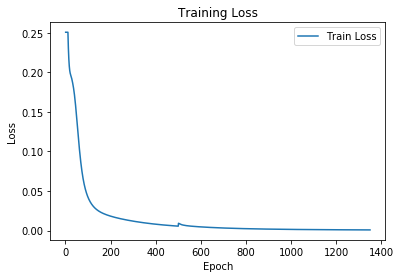

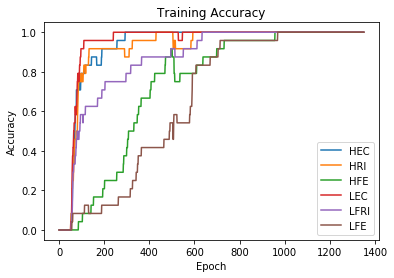

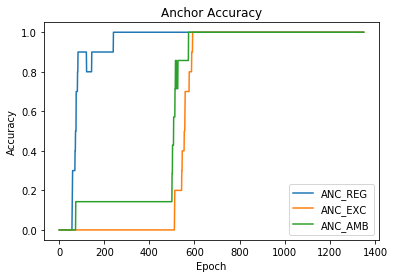

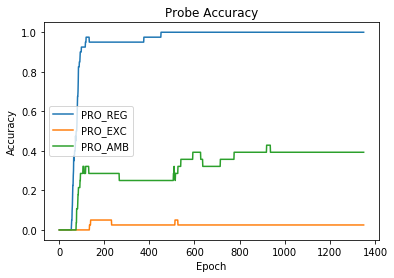

[EPOCH 1351] 	 loss: 0.000800 	 time: 0.8742 
[EPOCH 1352] 	 loss: 0.000798 	 time: 0.9062 
[EPOCH 1353] 	 loss: 0.000797 	 time: 0.8770 
[EPOCH 1354] 	 loss: 0.000796 	 time: 0.9287 
[EPOCH 1355] 	 loss: 0.000795 	 time: 0.8608 
[EPOCH 1356] 	 loss: 0.000794 	 time: 0.9540 
[EPOCH 1357] 	 loss: 0.000793 	 time: 1.0886 
[EPOCH 1358] 	 loss: 0.000792 	 time: 0.8862 
[EPOCH 1359] 	 loss: 0.000791 	 time: 0.9270 
[EPOCH 1360] 	 loss: 0.000790 	 time: 0.8706 
[EPOCH 1361] 	 loss: 0.000789 	 time: 0.9148 
[EPOCH 1362] 	 loss: 0.000788 	 time: 0.8683 
[EPOCH 1363] 	 loss: 0.000787 	 time: 0.8619 
[EPOCH 1364] 	 loss: 0.000786 	 time: 0.9008 
[EPOCH 1365] 	 loss: 0.000785 	 time: 0.8804 
[EPOCH 1366] 	 loss: 0.000784 	 time: 0.9112 
[EPOCH 1367] 	 loss: 0.000783 	 time: 0.8894 
[EPOCH 1368] 	 loss: 0.000782 	 time: 0.9169 
[EPOCH 1369] 	 loss: 0.000781 	 time: 0.8819 
[EPOCH 1370] 	 loss: 0.000780 	 time: 1.0424 
[EPOCH 1371] 	 loss: 0.000779 	 time: 1.0046 
[EPOCH 1372] 	 loss: 0.000778 	 ti

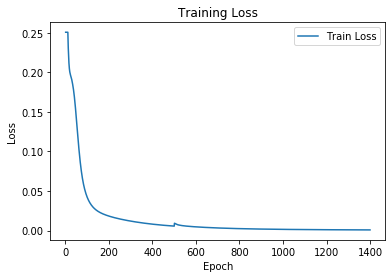

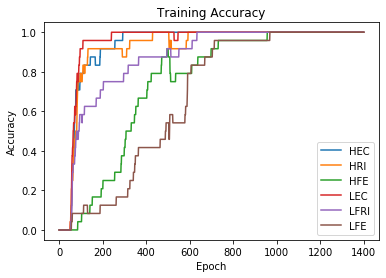

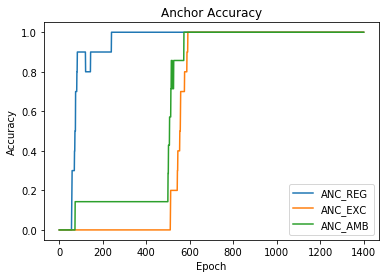

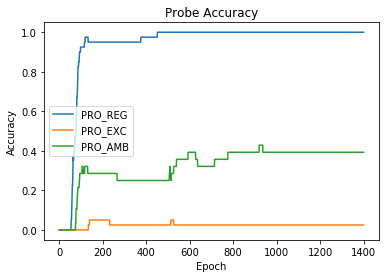

[EPOCH 1401] 	 loss: 0.000751 	 time: 0.9267 
[EPOCH 1402] 	 loss: 0.000750 	 time: 0.8976 
[EPOCH 1403] 	 loss: 0.000749 	 time: 0.9349 
[EPOCH 1404] 	 loss: 0.000748 	 time: 0.8555 
[EPOCH 1405] 	 loss: 0.000747 	 time: 0.9118 
[EPOCH 1406] 	 loss: 0.000746 	 time: 0.8641 
[EPOCH 1407] 	 loss: 0.000745 	 time: 0.8641 
[EPOCH 1408] 	 loss: 0.000744 	 time: 0.8841 
[EPOCH 1409] 	 loss: 0.000743 	 time: 0.8757 
[EPOCH 1410] 	 loss: 0.000742 	 time: 0.9153 
[EPOCH 1411] 	 loss: 0.000742 	 time: 0.8678 
[EPOCH 1412] 	 loss: 0.000741 	 time: 0.9025 
[EPOCH 1413] 	 loss: 0.000740 	 time: 0.8563 
[EPOCH 1414] 	 loss: 0.000739 	 time: 0.9348 
[EPOCH 1415] 	 loss: 0.000738 	 time: 0.8718 
[EPOCH 1416] 	 loss: 0.000737 	 time: 0.8895 
[EPOCH 1417] 	 loss: 0.000736 	 time: 0.9009 
[EPOCH 1418] 	 loss: 0.000735 	 time: 0.8775 
[EPOCH 1419] 	 loss: 0.000734 	 time: 0.9140 
[EPOCH 1420] 	 loss: 0.000734 	 time: 0.8649 
[EPOCH 1421] 	 loss: 0.000733 	 time: 0.9203 
[EPOCH 1422] 	 loss: 0.000732 	 ti

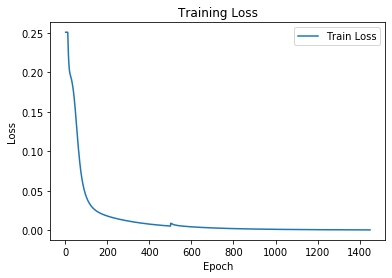

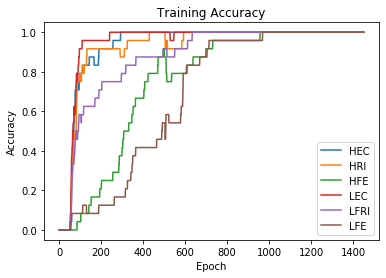

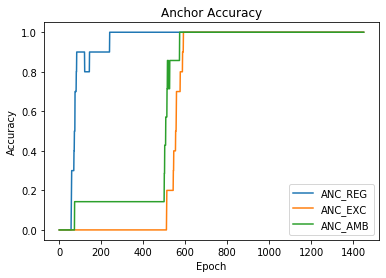

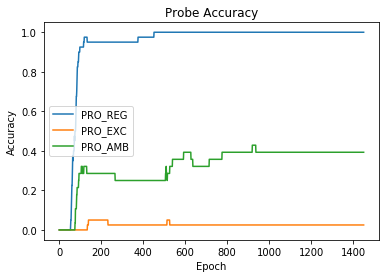

[EPOCH 1451] 	 loss: 0.000707 	 time: 0.8864 
[EPOCH 1452] 	 loss: 0.000707 	 time: 0.9330 
[EPOCH 1453] 	 loss: 0.000706 	 time: 0.8903 
[EPOCH 1454] 	 loss: 0.000705 	 time: 0.9427 
[EPOCH 1455] 	 loss: 0.000704 	 time: 0.8845 
[EPOCH 1456] 	 loss: 0.000703 	 time: 0.9122 
[EPOCH 1457] 	 loss: 0.000703 	 time: 0.8818 
[EPOCH 1458] 	 loss: 0.000702 	 time: 0.8959 
[EPOCH 1459] 	 loss: 0.000701 	 time: 0.9520 
[EPOCH 1460] 	 loss: 0.000700 	 time: 0.8736 
[EPOCH 1461] 	 loss: 0.000699 	 time: 0.9122 
[EPOCH 1462] 	 loss: 0.000699 	 time: 0.8739 
[EPOCH 1463] 	 loss: 0.000698 	 time: 0.9343 
[EPOCH 1464] 	 loss: 0.000697 	 time: 0.8753 
[EPOCH 1465] 	 loss: 0.000696 	 time: 1.0402 
[EPOCH 1466] 	 loss: 0.000695 	 time: 0.8669 
[EPOCH 1467] 	 loss: 0.000695 	 time: 0.8510 
[EPOCH 1468] 	 loss: 0.000694 	 time: 0.9416 
[EPOCH 1469] 	 loss: 0.000693 	 time: 0.8527 
[EPOCH 1470] 	 loss: 0.000692 	 time: 0.9229 
[EPOCH 1471] 	 loss: 0.000692 	 time: 0.8491 
[EPOCH 1472] 	 loss: 0.000691 	 ti

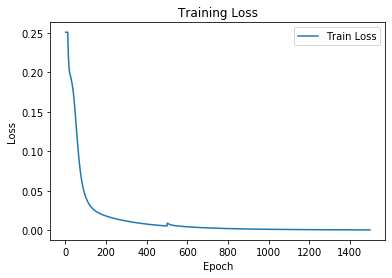

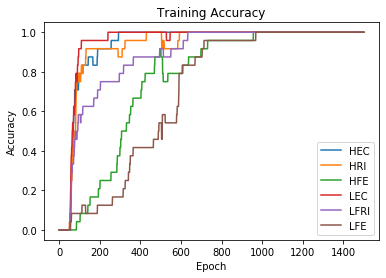

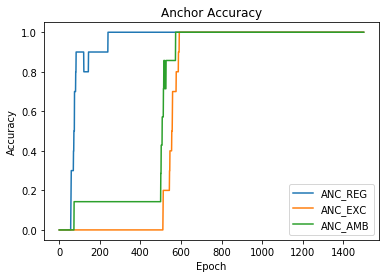

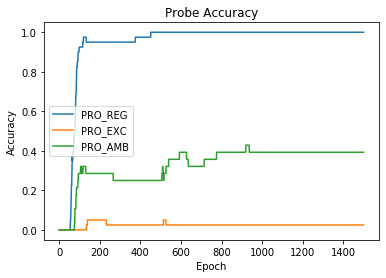

[EPOCH 1501] 	 loss: 0.000669 	 time: 0.9485 
[EPOCH 1502] 	 loss: 0.000668 	 time: 0.8635 
[EPOCH 1503] 	 loss: 0.000668 	 time: 0.9309 
[EPOCH 1504] 	 loss: 0.000667 	 time: 0.8604 
[EPOCH 1505] 	 loss: 0.000666 	 time: 0.9212 
[EPOCH 1506] 	 loss: 0.000666 	 time: 0.8711 
[EPOCH 1507] 	 loss: 0.000665 	 time: 0.9013 
[EPOCH 1508] 	 loss: 0.000664 	 time: 0.8875 
[EPOCH 1509] 	 loss: 0.000663 	 time: 0.8767 
[EPOCH 1510] 	 loss: 0.000663 	 time: 0.9199 
[EPOCH 1511] 	 loss: 0.000662 	 time: 0.8595 
[EPOCH 1512] 	 loss: 0.000661 	 time: 0.9274 
[EPOCH 1513] 	 loss: 0.000661 	 time: 0.8869 
[EPOCH 1514] 	 loss: 0.000660 	 time: 0.9354 
[EPOCH 1515] 	 loss: 0.000659 	 time: 0.8740 
[EPOCH 1516] 	 loss: 0.000659 	 time: 0.9005 
[EPOCH 1517] 	 loss: 0.000658 	 time: 0.8943 
[EPOCH 1518] 	 loss: 0.000657 	 time: 0.8637 
[EPOCH 1519] 	 loss: 0.000656 	 time: 0.9875 
[EPOCH 1520] 	 loss: 0.000656 	 time: 0.8813 
[EPOCH 1521] 	 loss: 0.000655 	 time: 0.8812 
[EPOCH 1522] 	 loss: 0.000654 	 ti

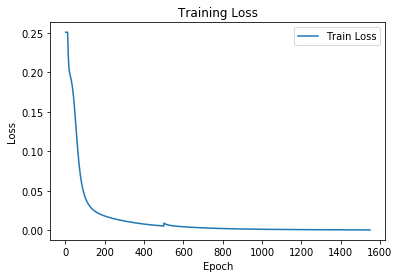

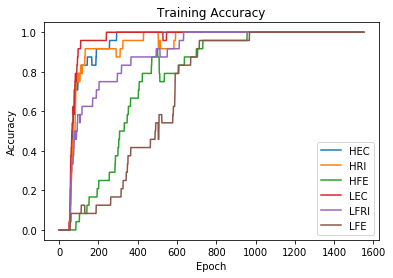

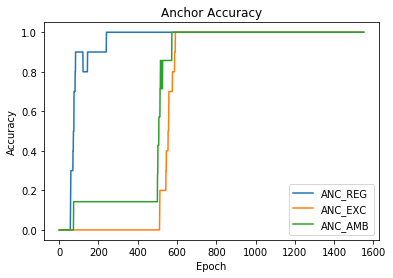

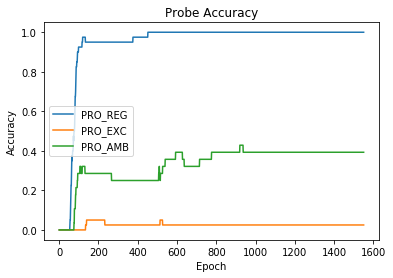

[EPOCH 1551] 	 loss: 0.000635 	 time: 0.8623 
[EPOCH 1552] 	 loss: 0.000634 	 time: 0.9247 
[EPOCH 1553] 	 loss: 0.000634 	 time: 0.9170 
[EPOCH 1554] 	 loss: 0.000633 	 time: 0.9082 
[EPOCH 1555] 	 loss: 0.000633 	 time: 0.8872 
[EPOCH 1556] 	 loss: 0.000632 	 time: 0.9291 
[EPOCH 1557] 	 loss: 0.000631 	 time: 0.9177 
[EPOCH 1558] 	 loss: 0.000631 	 time: 0.9182 
[EPOCH 1559] 	 loss: 0.000630 	 time: 0.9060 
[EPOCH 1560] 	 loss: 0.000629 	 time: 0.8723 
[EPOCH 1561] 	 loss: 0.000629 	 time: 0.9242 
[EPOCH 1562] 	 loss: 0.000628 	 time: 1.0016 
[EPOCH 1563] 	 loss: 0.000627 	 time: 0.9133 
[EPOCH 1564] 	 loss: 0.000627 	 time: 1.0316 
[EPOCH 1565] 	 loss: 0.000626 	 time: 1.0266 
[EPOCH 1566] 	 loss: 0.000626 	 time: 0.8640 
[EPOCH 1567] 	 loss: 0.000625 	 time: 0.9073 
[EPOCH 1568] 	 loss: 0.000624 	 time: 0.8857 
[EPOCH 1569] 	 loss: 0.000624 	 time: 0.8686 
[EPOCH 1570] 	 loss: 0.000623 	 time: 0.9400 
[EPOCH 1571] 	 loss: 0.000623 	 time: 0.9723 
[EPOCH 1572] 	 loss: 0.000622 	 ti

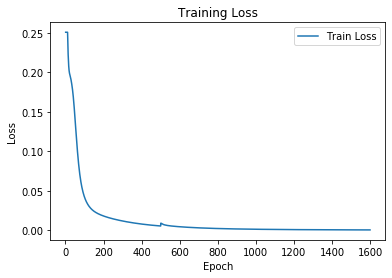

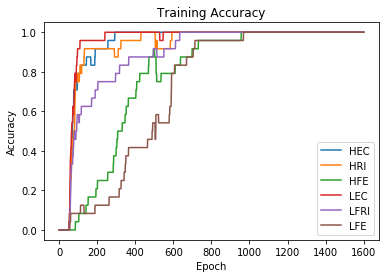

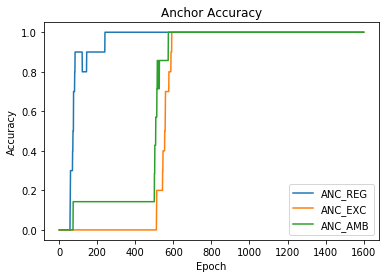

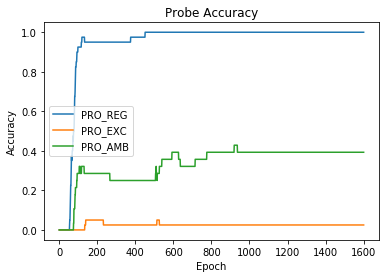

[EPOCH 1601] 	 loss: 0.000605 	 time: 0.8728 
[EPOCH 1602] 	 loss: 0.000604 	 time: 0.8642 
[EPOCH 1603] 	 loss: 0.000603 	 time: 0.9211 
[EPOCH 1604] 	 loss: 0.000603 	 time: 0.8987 
[EPOCH 1605] 	 loss: 0.000602 	 time: 0.9273 
[EPOCH 1606] 	 loss: 0.000602 	 time: 0.8908 
[EPOCH 1607] 	 loss: 0.000601 	 time: 0.9027 
[EPOCH 1608] 	 loss: 0.000601 	 time: 0.8723 
[EPOCH 1609] 	 loss: 0.000600 	 time: 0.9020 
[EPOCH 1610] 	 loss: 0.000599 	 time: 0.8573 
[EPOCH 1611] 	 loss: 0.000599 	 time: 0.8716 
[EPOCH 1612] 	 loss: 0.000598 	 time: 0.9298 
[EPOCH 1613] 	 loss: 0.000598 	 time: 0.8841 
[EPOCH 1614] 	 loss: 0.000597 	 time: 1.1038 
[EPOCH 1615] 	 loss: 0.000597 	 time: 0.9888 
[EPOCH 1616] 	 loss: 0.000596 	 time: 0.9237 
[EPOCH 1617] 	 loss: 0.000596 	 time: 0.8854 
[EPOCH 1618] 	 loss: 0.000595 	 time: 0.9095 
[EPOCH 1619] 	 loss: 0.000594 	 time: 0.8883 
[EPOCH 1620] 	 loss: 0.000594 	 time: 0.9401 
[EPOCH 1621] 	 loss: 0.000593 	 time: 0.8459 
[EPOCH 1622] 	 loss: 0.000593 	 ti

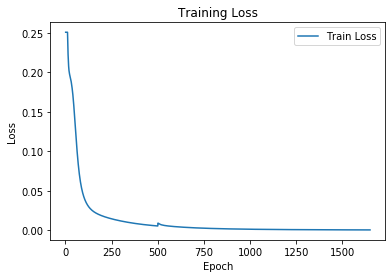

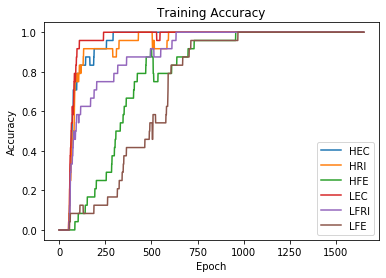

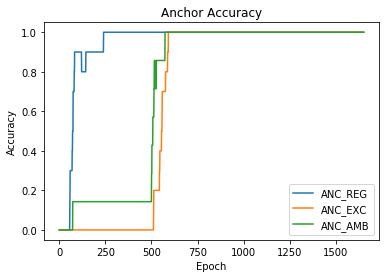

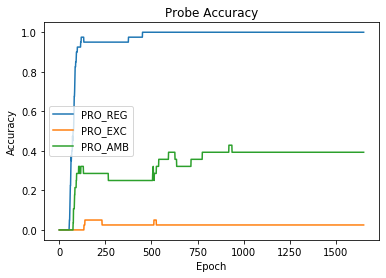

[EPOCH 1651] 	 loss: 0.000577 	 time: 0.9506 
[EPOCH 1652] 	 loss: 0.000577 	 time: 0.8671 
[EPOCH 1653] 	 loss: 0.000576 	 time: 0.8904 
[EPOCH 1654] 	 loss: 0.000576 	 time: 0.9225 
[EPOCH 1655] 	 loss: 0.000575 	 time: 1.0175 
[EPOCH 1656] 	 loss: 0.000575 	 time: 1.0062 
[EPOCH 1657] 	 loss: 0.000574 	 time: 0.8731 
[EPOCH 1658] 	 loss: 0.000574 	 time: 0.9548 
[EPOCH 1659] 	 loss: 0.000573 	 time: 0.8661 
[EPOCH 1660] 	 loss: 0.000573 	 time: 0.9362 
[EPOCH 1661] 	 loss: 0.000572 	 time: 0.8956 
[EPOCH 1662] 	 loss: 0.000572 	 time: 0.8951 
[EPOCH 1663] 	 loss: 0.000571 	 time: 0.9000 
[EPOCH 1664] 	 loss: 0.000571 	 time: 0.8506 
[EPOCH 1665] 	 loss: 0.000570 	 time: 0.9158 
[EPOCH 1666] 	 loss: 0.000570 	 time: 0.8578 
[EPOCH 1667] 	 loss: 0.000569 	 time: 0.9274 
[EPOCH 1668] 	 loss: 0.000569 	 time: 0.8405 
[EPOCH 1669] 	 loss: 0.000568 	 time: 1.0199 
[EPOCH 1670] 	 loss: 0.000568 	 time: 0.8860 
[EPOCH 1671] 	 loss: 0.000567 	 time: 0.8926 
[EPOCH 1672] 	 loss: 0.000567 	 ti

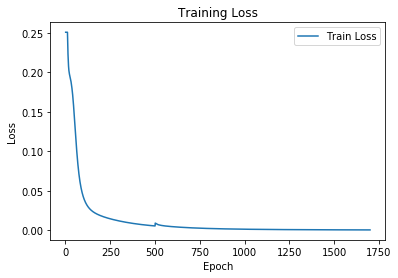

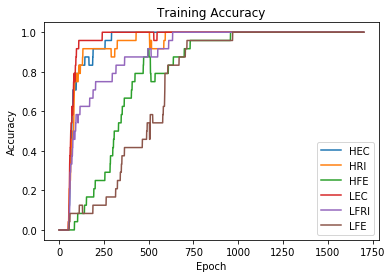

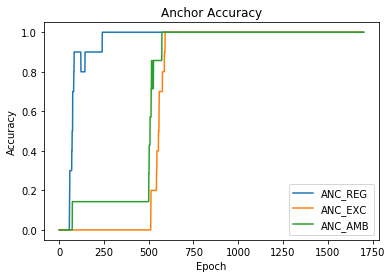

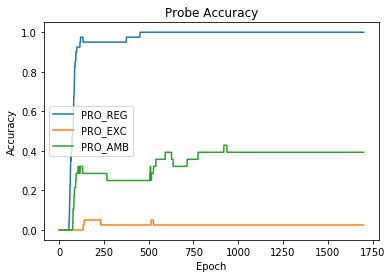

[EPOCH 1701] 	 loss: 0.000553 	 time: 0.8671 
[EPOCH 1702] 	 loss: 0.000552 	 time: 0.9228 
[EPOCH 1703] 	 loss: 0.000552 	 time: 0.8655 
[EPOCH 1704] 	 loss: 0.000551 	 time: 0.9202 
[EPOCH 1705] 	 loss: 0.000551 	 time: 0.8727 
[EPOCH 1706] 	 loss: 0.000550 	 time: 0.8741 
[EPOCH 1707] 	 loss: 0.000550 	 time: 0.9273 
[EPOCH 1708] 	 loss: 0.000549 	 time: 0.8949 
[EPOCH 1709] 	 loss: 0.000549 	 time: 0.9235 
[EPOCH 1710] 	 loss: 0.000548 	 time: 0.8786 
[EPOCH 1711] 	 loss: 0.000548 	 time: 0.9180 
[EPOCH 1712] 	 loss: 0.000547 	 time: 0.9065 
[EPOCH 1713] 	 loss: 0.000547 	 time: 0.8837 
[EPOCH 1714] 	 loss: 0.000546 	 time: 0.9456 
[EPOCH 1715] 	 loss: 0.000546 	 time: 0.8869 
[EPOCH 1716] 	 loss: 0.000546 	 time: 0.9299 
[EPOCH 1717] 	 loss: 0.000545 	 time: 0.8769 
[EPOCH 1718] 	 loss: 0.000545 	 time: 0.9192 
[EPOCH 1719] 	 loss: 0.000544 	 time: 0.8822 
[EPOCH 1720] 	 loss: 0.000544 	 time: 0.9180 
[EPOCH 1721] 	 loss: 0.000543 	 time: 0.8380 
[EPOCH 1722] 	 loss: 0.000543 	 ti

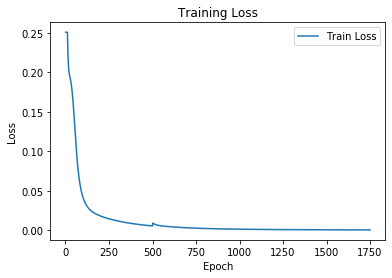

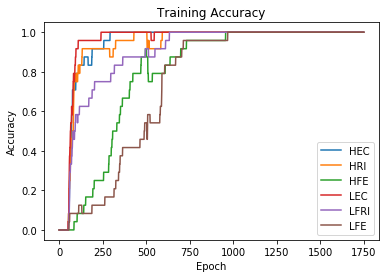

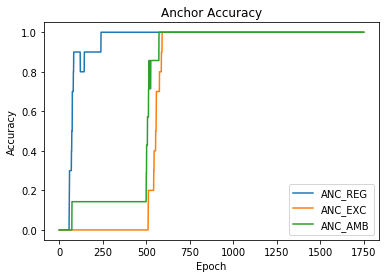

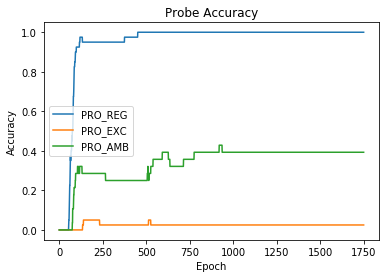

[EPOCH 1751] 	 loss: 0.000530 	 time: 0.8959 
[EPOCH 1752] 	 loss: 0.000530 	 time: 0.8807 
[EPOCH 1753] 	 loss: 0.000529 	 time: 0.9147 
[EPOCH 1754] 	 loss: 0.000529 	 time: 0.9053 
[EPOCH 1755] 	 loss: 0.000528 	 time: 0.9016 
[EPOCH 1756] 	 loss: 0.000528 	 time: 0.9433 
[EPOCH 1757] 	 loss: 0.000528 	 time: 0.8978 
[EPOCH 1758] 	 loss: 0.000527 	 time: 0.9243 
[EPOCH 1759] 	 loss: 0.000527 	 time: 0.8758 
[EPOCH 1760] 	 loss: 0.000526 	 time: 1.0330 
[EPOCH 1761] 	 loss: 0.000526 	 time: 0.8891 
[EPOCH 1762] 	 loss: 0.000526 	 time: 0.8844 
[EPOCH 1763] 	 loss: 0.000525 	 time: 0.9008 
[EPOCH 1764] 	 loss: 0.000525 	 time: 0.9009 
[EPOCH 1765] 	 loss: 0.000524 	 time: 0.8781 
[EPOCH 1766] 	 loss: 0.000524 	 time: 0.8705 
[EPOCH 1767] 	 loss: 0.000523 	 time: 0.9531 
[EPOCH 1768] 	 loss: 0.000523 	 time: 0.8618 
[EPOCH 1769] 	 loss: 0.000523 	 time: 0.9218 
[EPOCH 1770] 	 loss: 0.000522 	 time: 0.8702 
[EPOCH 1771] 	 loss: 0.000522 	 time: 0.9206 
[EPOCH 1772] 	 loss: 0.000521 	 ti

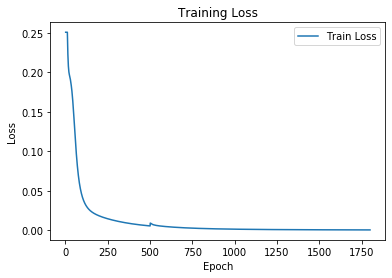

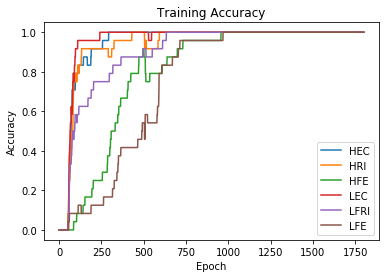

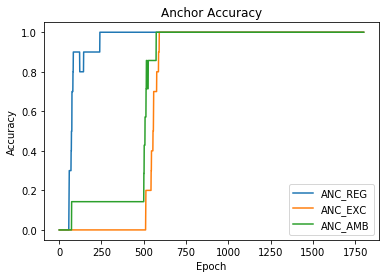

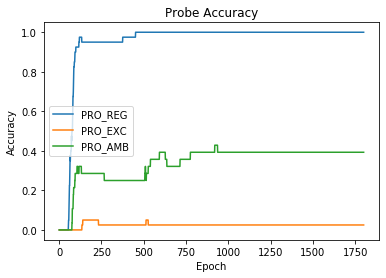

[EPOCH 1801] 	 loss: 0.000510 	 time: 0.8913 
[EPOCH 1802] 	 loss: 0.000509 	 time: 0.9326 
[EPOCH 1803] 	 loss: 0.000509 	 time: 0.9841 
[EPOCH 1804] 	 loss: 0.000509 	 time: 0.9321 
[EPOCH 1805] 	 loss: 0.000508 	 time: 0.8564 
[EPOCH 1806] 	 loss: 0.000508 	 time: 0.9307 
[EPOCH 1807] 	 loss: 0.000508 	 time: 0.8704 
[EPOCH 1808] 	 loss: 0.000507 	 time: 0.8659 
[EPOCH 1809] 	 loss: 0.000507 	 time: 0.9177 
[EPOCH 1810] 	 loss: 0.000506 	 time: 0.8944 
[EPOCH 1811] 	 loss: 0.000506 	 time: 0.9338 
[EPOCH 1812] 	 loss: 0.000506 	 time: 0.8879 
[EPOCH 1813] 	 loss: 0.000505 	 time: 0.9215 
[EPOCH 1814] 	 loss: 0.000505 	 time: 0.8898 
[EPOCH 1815] 	 loss: 0.000505 	 time: 0.8902 
[EPOCH 1816] 	 loss: 0.000504 	 time: 0.8627 
[EPOCH 1817] 	 loss: 0.000504 	 time: 0.8931 
[EPOCH 1818] 	 loss: 0.000503 	 time: 0.9088 
[EPOCH 1819] 	 loss: 0.000503 	 time: 0.9008 
[EPOCH 1820] 	 loss: 0.000503 	 time: 0.9252 
[EPOCH 1821] 	 loss: 0.000502 	 time: 0.8992 
[EPOCH 1822] 	 loss: 0.000502 	 ti

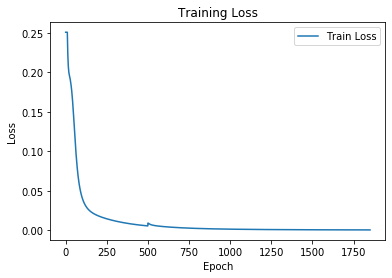

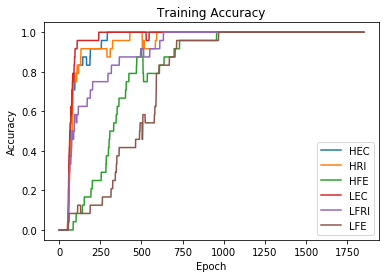

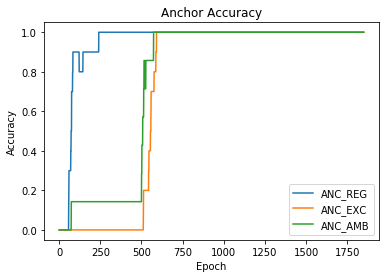

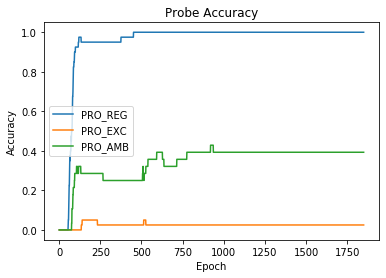

[EPOCH 1851] 	 loss: 0.000491 	 time: 0.9667 
[EPOCH 1852] 	 loss: 0.000491 	 time: 0.8787 
[EPOCH 1853] 	 loss: 0.000491 	 time: 0.8926 
[EPOCH 1854] 	 loss: 0.000490 	 time: 0.8482 
[EPOCH 1855] 	 loss: 0.000490 	 time: 0.9293 
[EPOCH 1856] 	 loss: 0.000490 	 time: 0.8773 
[EPOCH 1857] 	 loss: 0.000489 	 time: 0.9003 
[EPOCH 1858] 	 loss: 0.000489 	 time: 0.8668 
[EPOCH 1859] 	 loss: 0.000489 	 time: 0.8793 
[EPOCH 1860] 	 loss: 0.000488 	 time: 0.9087 
[EPOCH 1861] 	 loss: 0.000488 	 time: 0.8869 
[EPOCH 1862] 	 loss: 0.000488 	 time: 0.9294 
[EPOCH 1863] 	 loss: 0.000487 	 time: 0.8721 
[EPOCH 1864] 	 loss: 0.000487 	 time: 0.9379 
[EPOCH 1865] 	 loss: 0.000487 	 time: 0.8371 
[EPOCH 1866] 	 loss: 0.000486 	 time: 0.9319 
[EPOCH 1867] 	 loss: 0.000486 	 time: 0.8790 
[EPOCH 1868] 	 loss: 0.000485 	 time: 0.8786 
[EPOCH 1869] 	 loss: 0.000485 	 time: 0.8995 
[EPOCH 1870] 	 loss: 0.000485 	 time: 0.8740 
[EPOCH 1871] 	 loss: 0.000484 	 time: 1.0877 
[EPOCH 1872] 	 loss: 0.000484 	 ti

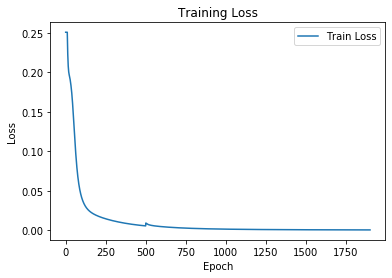

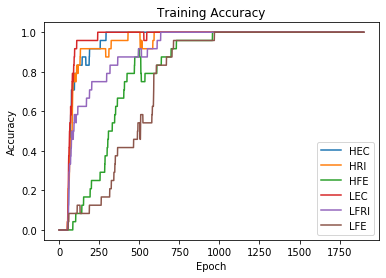

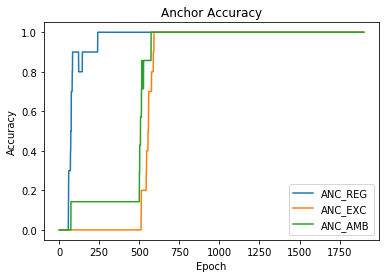

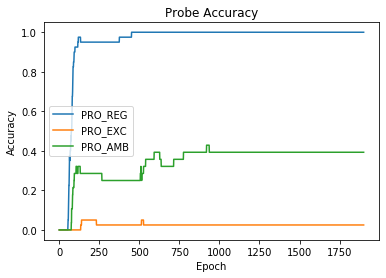

[EPOCH 1901] 	 loss: 0.000475 	 time: 0.8906 
[EPOCH 1902] 	 loss: 0.000474 	 time: 0.9205 
[EPOCH 1903] 	 loss: 0.000474 	 time: 0.8856 
[EPOCH 1904] 	 loss: 0.000474 	 time: 0.9495 
[EPOCH 1905] 	 loss: 0.000473 	 time: 0.9065 
[EPOCH 1906] 	 loss: 0.000473 	 time: 0.9335 
[EPOCH 1907] 	 loss: 0.000473 	 time: 0.8516 
[EPOCH 1908] 	 loss: 0.000472 	 time: 0.9263 
[EPOCH 1909] 	 loss: 0.000472 	 time: 0.8520 
[EPOCH 1910] 	 loss: 0.000472 	 time: 0.8715 
[EPOCH 1911] 	 loss: 0.000471 	 time: 0.9069 
[EPOCH 1912] 	 loss: 0.000471 	 time: 0.8769 
[EPOCH 1913] 	 loss: 0.000471 	 time: 1.1711 
[EPOCH 1914] 	 loss: 0.000470 	 time: 0.8953 
[EPOCH 1915] 	 loss: 0.000470 	 time: 0.9356 
[EPOCH 1916] 	 loss: 0.000470 	 time: 0.8328 
[EPOCH 1917] 	 loss: 0.000469 	 time: 0.8988 
[EPOCH 1918] 	 loss: 0.000469 	 time: 0.8459 
[EPOCH 1919] 	 loss: 0.000469 	 time: 0.8678 
[EPOCH 1920] 	 loss: 0.000468 	 time: 0.9232 
[EPOCH 1921] 	 loss: 0.000468 	 time: 0.8851 
[EPOCH 1922] 	 loss: 0.000468 	 ti

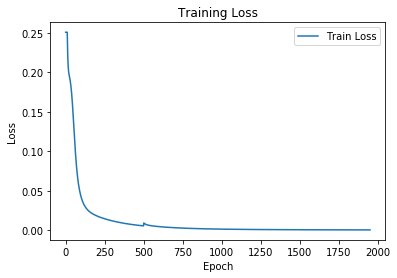

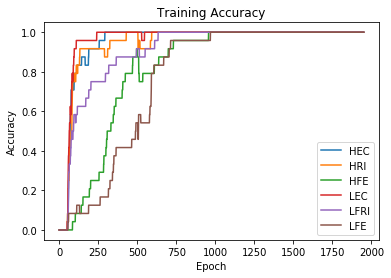

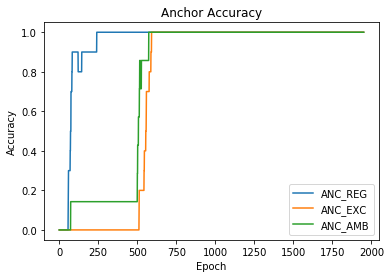

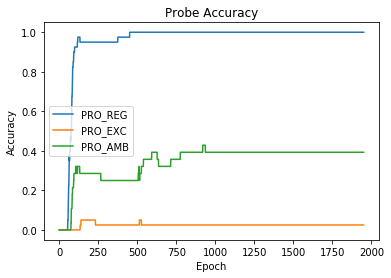

[EPOCH 1951] 	 loss: 0.000459 	 time: 0.8636 
[EPOCH 1952] 	 loss: 0.000459 	 time: 0.8768 
[EPOCH 1953] 	 loss: 0.000458 	 time: 0.9310 
[EPOCH 1954] 	 loss: 0.000458 	 time: 0.8891 
[EPOCH 1955] 	 loss: 0.000458 	 time: 0.9932 
[EPOCH 1956] 	 loss: 0.000458 	 time: 0.9367 
[EPOCH 1957] 	 loss: 0.000457 	 time: 1.0661 
[EPOCH 1958] 	 loss: 0.000457 	 time: 0.8698 
[EPOCH 1959] 	 loss: 0.000457 	 time: 0.9163 
[EPOCH 1960] 	 loss: 0.000456 	 time: 0.9048 
[EPOCH 1961] 	 loss: 0.000456 	 time: 0.8816 
[EPOCH 1962] 	 loss: 0.000456 	 time: 0.9052 
[EPOCH 1963] 	 loss: 0.000456 	 time: 0.8361 
[EPOCH 1964] 	 loss: 0.000455 	 time: 0.9237 
[EPOCH 1965] 	 loss: 0.000455 	 time: 0.8643 
[EPOCH 1966] 	 loss: 0.000455 	 time: 0.9242 
[EPOCH 1967] 	 loss: 0.000454 	 time: 0.8599 
[EPOCH 1968] 	 loss: 0.000454 	 time: 0.9143 
[EPOCH 1969] 	 loss: 0.000454 	 time: 0.9063 
[EPOCH 1970] 	 loss: 0.000454 	 time: 0.9162 
[EPOCH 1971] 	 loss: 0.000453 	 time: 0.9078 
[EPOCH 1972] 	 loss: 0.000453 	 ti

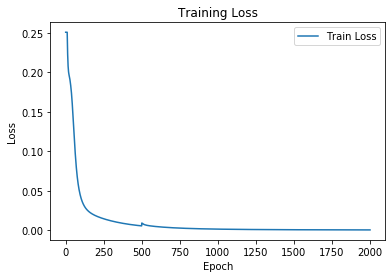

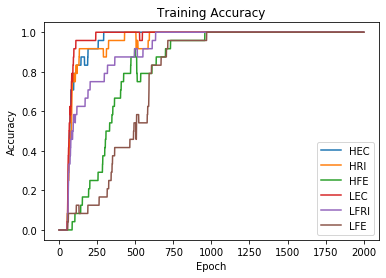

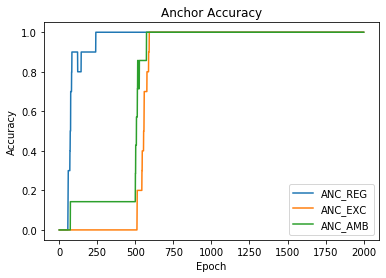

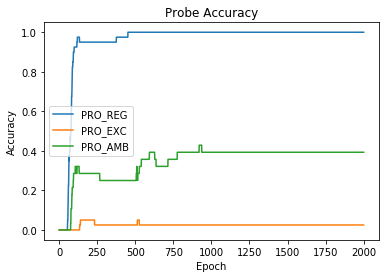

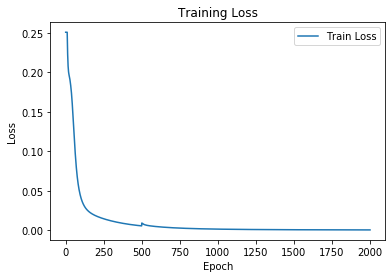

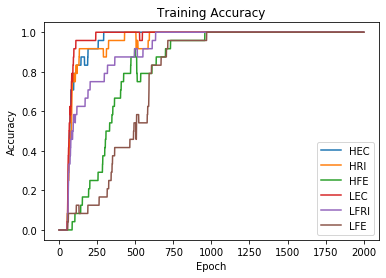

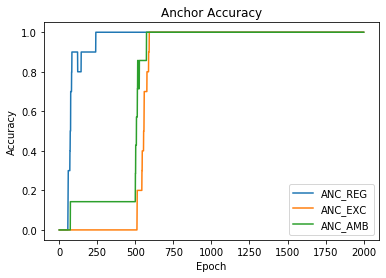

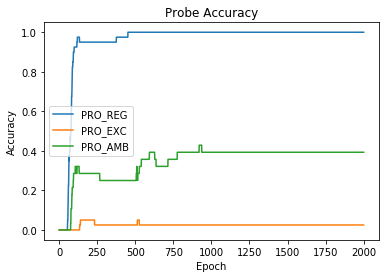

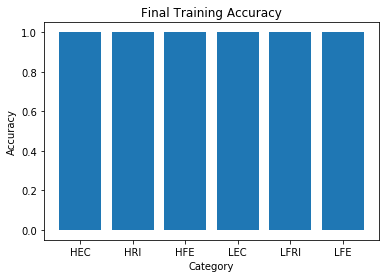

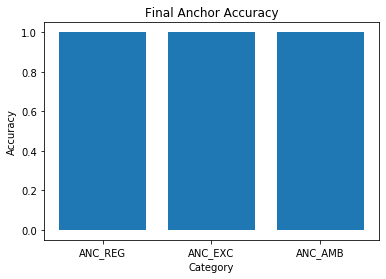

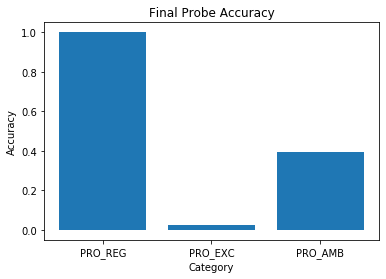

Training Completed!
Add any notes below to save with results:
 > 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from simulator import *
sim = simulator()
sim.train()

### Training Function (old)

In [4]:
def train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, folder, lr=0.001):
    # define loss function and optimizer
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize arrays to store epochs, train loss
    epochs, losses = [], []
    
    # Select word types to calculate accuracy for
    types = ["HEC", "HRI", "HFE", "LEC", "LFRI", "LFEEXPT"] # calculate accuracy of these types
    anc_types = ["ANC_REG", "ANC_EXC", "ANC_AMB"]
    probe_types = ["PRO_REG", "PRO_EXC", "PRO_AMB"]
    
    # Initialize arrays to store accuracy of plaut dataset, anchors, probes
    acc = [[], [], [], []]
    anc_acc = [[] for i in anc_types]
    probe_acc = [[] for i in probe_types]
    
    for epoch in range(600):
        if epoch < 500: # use only plaut dataset for first 500 epochs
            data_loader = plaut_loader
        else: # after, train with both plaut + anchors
            data_loader = plaut_anc_loader
        
        avg_loss = 0 # initialize avg loss
        for i, data in enumerate(data_loader): 
            # extract frequency, inputs, labels
            freq = data["frequency"].float().view(-1, 1) # reshape to [batch_size x 1] to match output size
            inputs = data["graphemes"].float()
            labels = data["phonemes"].float()
            
            #forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = (loss*freq).mean() # scale loss by frequency, then find mean
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # calculate loss and save loss to array
        losses.append(avg_loss)
        epochs.append(epoch+1)
        
        # calculate accuracy over the different types for plaut dataset
        temp_acc = get_accuracy(model, plaut_loader, types)
        acc[0].append((temp_acc[0]+temp_acc[1])/2) # average of HFR consistent and inconsistent
        acc[1].append(temp_acc[2]) # HFE
        acc[2].append((temp_acc[3]+temp_acc[4])/2) # average of LFR consistent and inconsistent
        acc[3].append(temp_acc[5]) # LFE
        
        # calculate accuracy over the different types for anchors
        temp_acc = get_accuracy(model, anc_loader, anc_types, vowels_only=True)
        for i in range(len(anc_types)):
            anc_acc[i].append(temp_acc[i])
            
        # calculate accuracy over the different types for probes
        temp_acc = get_accuracy(model, probe_loader, probe_types, vowels_only=True)
        for i in range(len(probe_types)):
            probe_acc[i].append(temp_acc[i])
        
        # print stats every 5 epochs
        if epoch % 1 == 0:
            print("[EPOCH %d] loss: %.6f" % (epoch+1, avg_loss))
        
        # plot loss every 5 epochs
        if epoch % 50 == 49:
            make_plot(epochs, [losses], ["Train Loss"], "Epoch", "Loss", "Training Loss")
            make_plot(epochs, acc, ["HFR", "HFE", "LFR", "LFE"], "Epoch", "Accuracy", "Training Accuracy")
            make_plot(epochs, anc_acc, anc_types, "Epoch", "Accuracy", "Anchor Accuracy")
            make_plot(epochs, probe_acc, probe_types, "Epoch", "Accuracy", "Probe Accuracy")
            

    # plot final loss curve and save
    plt.figure()
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(losses, label="Training Loss")
    plt.savefig(rootdir+"/lossplot_final.png", dpi=150)
    plt.close()

### Training

Test Results saved in : /Users/BrianLam/UTSC Research/Plaut_Model/results/jan01_test01
[EPOCH 1] loss: 2.005025
[EPOCH 2] loss: 0.761653
[EPOCH 3] loss: 0.916140
[EPOCH 4] loss: 0.833535
[EPOCH 5] loss: 0.683057
[EPOCH 6] loss: 0.583609
[EPOCH 7] loss: 0.580636
[EPOCH 8] loss: 0.625002
[EPOCH 9] loss: 0.653815
[EPOCH 10] loss: 0.647629
[EPOCH 11] loss: 0.615382
[EPOCH 12] loss: 0.576462
[EPOCH 13] loss: 0.549712
[EPOCH 14] loss: 0.544086
[EPOCH 15] loss: 0.554972
[EPOCH 16] loss: 0.569968
[EPOCH 17] loss: 0.578402
[EPOCH 18] loss: 0.576153
[EPOCH 19] loss: 0.565118
[EPOCH 20] loss: 0.550576
[EPOCH 21] loss: 0.538279
[EPOCH 22] loss: 0.531908
[EPOCH 23] loss: 0.531679
[EPOCH 24] loss: 0.534836
[EPOCH 25] loss: 0.537646
[EPOCH 26] loss: 0.537471
[EPOCH 27] loss: 0.533734
[EPOCH 28] loss: 0.527637
[EPOCH 29] loss: 0.521171
[EPOCH 30] loss: 0.516019
[EPOCH 31] loss: 0.512850
[EPOCH 32] loss: 0.511229
[EPOCH 33] loss: 0.510051
[EPOCH 34] loss: 0.508133
[EPOCH 35] loss: 0.504707
[EPOCH 36] l

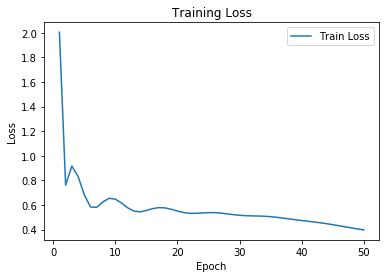

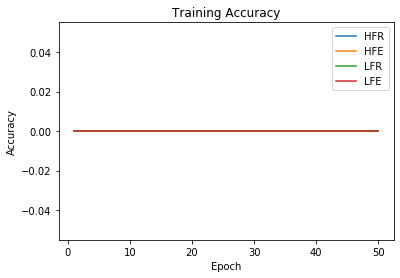

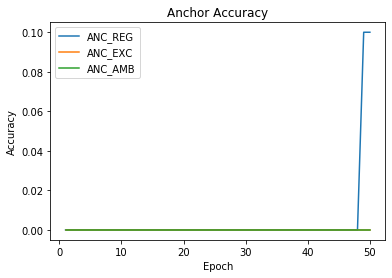

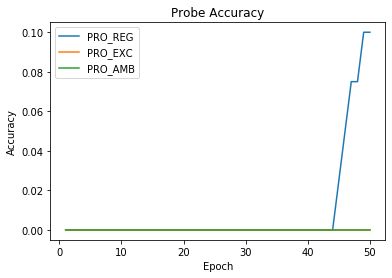

[EPOCH 51] loss: 0.388859
[EPOCH 52] loss: 0.380561
[EPOCH 53] loss: 0.372071
[EPOCH 54] loss: 0.363506
[EPOCH 55] loss: 0.355042
[EPOCH 56] loss: 0.346820
[EPOCH 57] loss: 0.338873
[EPOCH 58] loss: 0.331135
[EPOCH 59] loss: 0.323494
[EPOCH 60] loss: 0.315871
[EPOCH 61] loss: 0.308264
[EPOCH 62] loss: 0.300742
[EPOCH 63] loss: 0.293401
[EPOCH 64] loss: 0.286312
[EPOCH 65] loss: 0.279488
[EPOCH 66] loss: 0.272896
[EPOCH 67] loss: 0.266485
[EPOCH 68] loss: 0.260224
[EPOCH 69] loss: 0.254114
[EPOCH 70] loss: 0.248185
[EPOCH 71] loss: 0.242469
[EPOCH 72] loss: 0.236978
[EPOCH 73] loss: 0.231697
[EPOCH 74] loss: 0.226594
[EPOCH 75] loss: 0.221639
[EPOCH 76] loss: 0.216818
[EPOCH 77] loss: 0.212134
[EPOCH 78] loss: 0.207601
[EPOCH 79] loss: 0.203226
[EPOCH 80] loss: 0.199004
[EPOCH 81] loss: 0.194921
[EPOCH 82] loss: 0.190963
[EPOCH 83] loss: 0.187119
[EPOCH 84] loss: 0.183389
[EPOCH 85] loss: 0.179774
[EPOCH 86] loss: 0.176277
[EPOCH 87] loss: 0.172893
[EPOCH 88] loss: 0.169611
[EPOCH 89] l

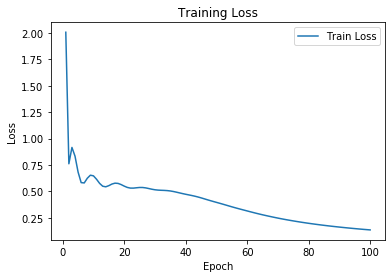

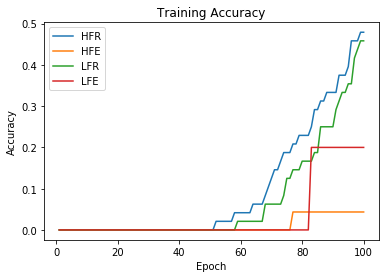

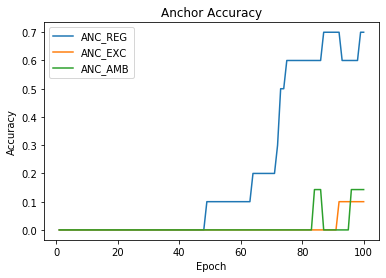

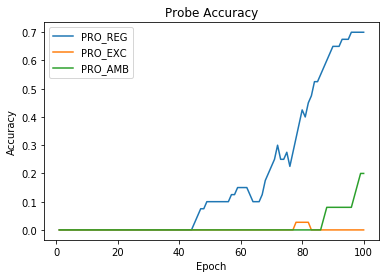

[EPOCH 101] loss: 0.134247
[EPOCH 102] loss: 0.132026
[EPOCH 103] loss: 0.129870
[EPOCH 104] loss: 0.127776
[EPOCH 105] loss: 0.125744
[EPOCH 106] loss: 0.123772
[EPOCH 107] loss: 0.121859
[EPOCH 108] loss: 0.120003
[EPOCH 109] loss: 0.118200
[EPOCH 110] loss: 0.116448
[EPOCH 111] loss: 0.114746
[EPOCH 112] loss: 0.113092
[EPOCH 113] loss: 0.111485
[EPOCH 114] loss: 0.109923
[EPOCH 115] loss: 0.108404
[EPOCH 116] loss: 0.106928
[EPOCH 117] loss: 0.105493
[EPOCH 118] loss: 0.104098
[EPOCH 119] loss: 0.102743
[EPOCH 120] loss: 0.101427
[EPOCH 121] loss: 0.100148
[EPOCH 122] loss: 0.098906
[EPOCH 123] loss: 0.097698
[EPOCH 124] loss: 0.096523
[EPOCH 125] loss: 0.095381
[EPOCH 126] loss: 0.094269
[EPOCH 127] loss: 0.093187
[EPOCH 128] loss: 0.092134
[EPOCH 129] loss: 0.091108
[EPOCH 130] loss: 0.090107
[EPOCH 131] loss: 0.089132
[EPOCH 132] loss: 0.088181
[EPOCH 133] loss: 0.087253
[EPOCH 134] loss: 0.086348
[EPOCH 135] loss: 0.085465
[EPOCH 136] loss: 0.084603
[EPOCH 137] loss: 0.083761
[

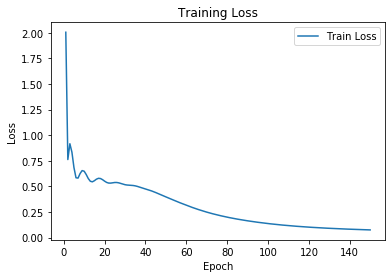

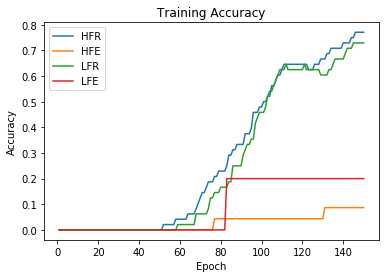

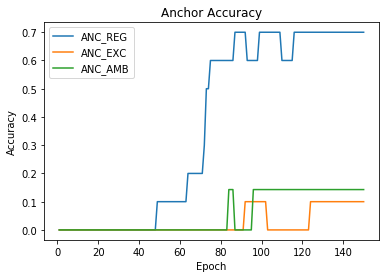

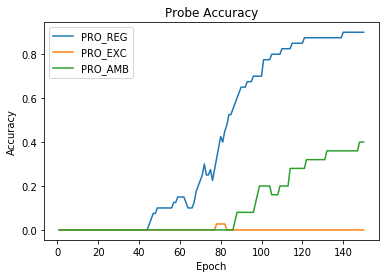

[EPOCH 151] loss: 0.073793
[EPOCH 152] loss: 0.073189
[EPOCH 153] loss: 0.072596
[EPOCH 154] loss: 0.072015
[EPOCH 155] loss: 0.071445
[EPOCH 156] loss: 0.070886
[EPOCH 157] loss: 0.070336
[EPOCH 158] loss: 0.069797
[EPOCH 159] loss: 0.069267
[EPOCH 160] loss: 0.068747
[EPOCH 161] loss: 0.068235
[EPOCH 162] loss: 0.067732
[EPOCH 163] loss: 0.067238
[EPOCH 164] loss: 0.066752
[EPOCH 165] loss: 0.066274
[EPOCH 166] loss: 0.065803
[EPOCH 167] loss: 0.065340
[EPOCH 168] loss: 0.064885
[EPOCH 169] loss: 0.064437
[EPOCH 170] loss: 0.063996
[EPOCH 171] loss: 0.063561
[EPOCH 172] loss: 0.063134
[EPOCH 173] loss: 0.062713
[EPOCH 174] loss: 0.062298
[EPOCH 175] loss: 0.061890
[EPOCH 176] loss: 0.061488
[EPOCH 177] loss: 0.061091
[EPOCH 178] loss: 0.060701
[EPOCH 179] loss: 0.060316
[EPOCH 180] loss: 0.059937
[EPOCH 181] loss: 0.059564
[EPOCH 182] loss: 0.059195
[EPOCH 183] loss: 0.058832
[EPOCH 184] loss: 0.058474
[EPOCH 185] loss: 0.058121
[EPOCH 186] loss: 0.057772
[EPOCH 187] loss: 0.057428
[

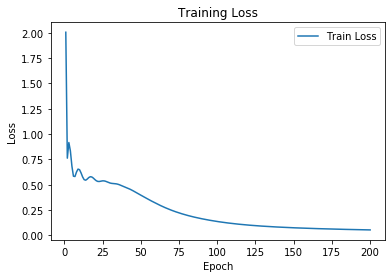

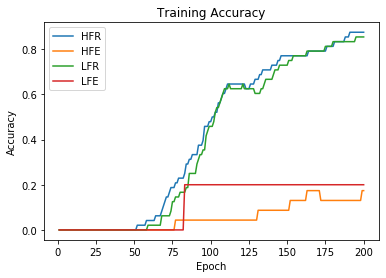

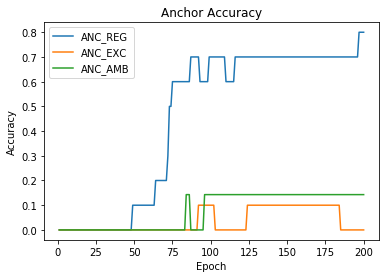

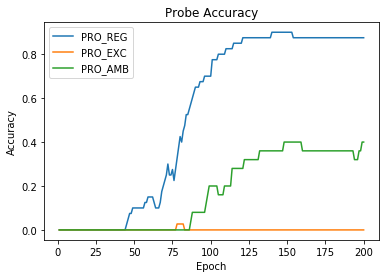

[EPOCH 201] loss: 0.053035
[EPOCH 202] loss: 0.052747
[EPOCH 203] loss: 0.052463
[EPOCH 204] loss: 0.052182
[EPOCH 205] loss: 0.051904
[EPOCH 206] loss: 0.051628
[EPOCH 207] loss: 0.051356
[EPOCH 208] loss: 0.051086
[EPOCH 209] loss: 0.050819
[EPOCH 210] loss: 0.050555
[EPOCH 211] loss: 0.050294
[EPOCH 212] loss: 0.050035
[EPOCH 213] loss: 0.049779
[EPOCH 214] loss: 0.049525
[EPOCH 215] loss: 0.049274
[EPOCH 216] loss: 0.049025
[EPOCH 217] loss: 0.048778
[EPOCH 218] loss: 0.048534
[EPOCH 219] loss: 0.048292
[EPOCH 220] loss: 0.048053
[EPOCH 221] loss: 0.047815
[EPOCH 222] loss: 0.047580
[EPOCH 223] loss: 0.047347
[EPOCH 224] loss: 0.047116
[EPOCH 225] loss: 0.046887
[EPOCH 226] loss: 0.046659
[EPOCH 227] loss: 0.046434
[EPOCH 228] loss: 0.046211
[EPOCH 229] loss: 0.045990
[EPOCH 230] loss: 0.045770
[EPOCH 231] loss: 0.045552
[EPOCH 232] loss: 0.045336
[EPOCH 233] loss: 0.045122
[EPOCH 234] loss: 0.044909
[EPOCH 235] loss: 0.044699
[EPOCH 236] loss: 0.044489
[EPOCH 237] loss: 0.044282
[

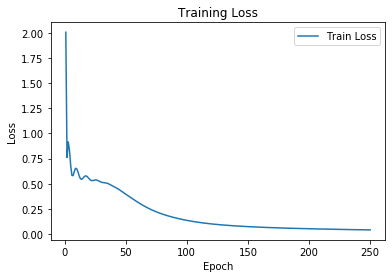

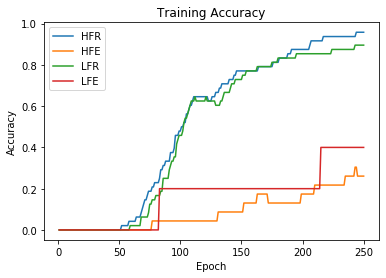

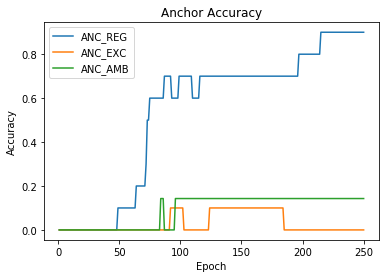

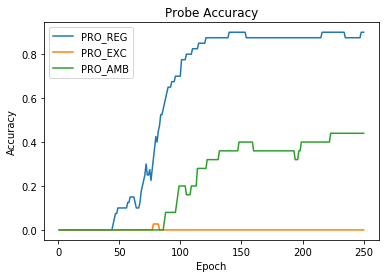

[EPOCH 251] loss: 0.041539
[EPOCH 252] loss: 0.041355
[EPOCH 253] loss: 0.041171
[EPOCH 254] loss: 0.040989
[EPOCH 255] loss: 0.040809
[EPOCH 256] loss: 0.040630
[EPOCH 257] loss: 0.040452
[EPOCH 258] loss: 0.040276
[EPOCH 259] loss: 0.040101
[EPOCH 260] loss: 0.039927
[EPOCH 261] loss: 0.039755
[EPOCH 262] loss: 0.039584
[EPOCH 263] loss: 0.039414
[EPOCH 264] loss: 0.039246
[EPOCH 265] loss: 0.039078
[EPOCH 266] loss: 0.038912
[EPOCH 267] loss: 0.038747
[EPOCH 268] loss: 0.038583
[EPOCH 269] loss: 0.038420
[EPOCH 270] loss: 0.038258
[EPOCH 271] loss: 0.038098
[EPOCH 272] loss: 0.037938
[EPOCH 273] loss: 0.037780
[EPOCH 274] loss: 0.037622
[EPOCH 275] loss: 0.037465
[EPOCH 276] loss: 0.037310
[EPOCH 277] loss: 0.037155
[EPOCH 278] loss: 0.037002
[EPOCH 279] loss: 0.036849
[EPOCH 280] loss: 0.036697
[EPOCH 281] loss: 0.036546
[EPOCH 282] loss: 0.036397
[EPOCH 283] loss: 0.036248
[EPOCH 284] loss: 0.036100
[EPOCH 285] loss: 0.035953
[EPOCH 286] loss: 0.035807
[EPOCH 287] loss: 0.035662
[

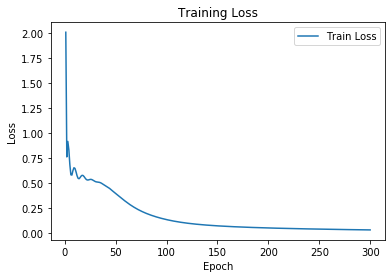

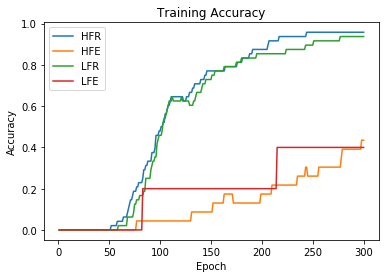

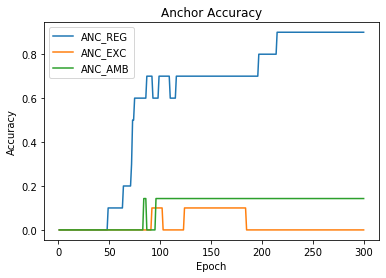

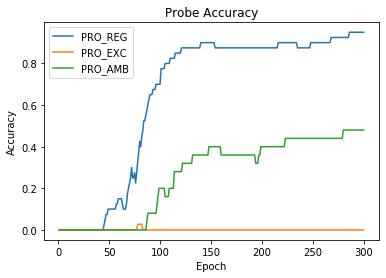

[EPOCH 301] loss: 0.033720
[EPOCH 302] loss: 0.033587
[EPOCH 303] loss: 0.033455
[EPOCH 304] loss: 0.033324
[EPOCH 305] loss: 0.033194
[EPOCH 306] loss: 0.033064
[EPOCH 307] loss: 0.032935
[EPOCH 308] loss: 0.032806
[EPOCH 309] loss: 0.032679
[EPOCH 310] loss: 0.032552
[EPOCH 311] loss: 0.032425
[EPOCH 312] loss: 0.032299
[EPOCH 313] loss: 0.032174
[EPOCH 314] loss: 0.032050
[EPOCH 315] loss: 0.031926
[EPOCH 316] loss: 0.031803
[EPOCH 317] loss: 0.031680
[EPOCH 318] loss: 0.031558
[EPOCH 319] loss: 0.031437
[EPOCH 320] loss: 0.031316
[EPOCH 321] loss: 0.031196
[EPOCH 322] loss: 0.031077
[EPOCH 323] loss: 0.030958
[EPOCH 324] loss: 0.030840
[EPOCH 325] loss: 0.030722
[EPOCH 326] loss: 0.030605
[EPOCH 327] loss: 0.030489
[EPOCH 328] loss: 0.030374
[EPOCH 329] loss: 0.030259
[EPOCH 330] loss: 0.030145
[EPOCH 331] loss: 0.030032
[EPOCH 332] loss: 0.029919
[EPOCH 333] loss: 0.029806
[EPOCH 334] loss: 0.029695
[EPOCH 335] loss: 0.029584
[EPOCH 336] loss: 0.029474
[EPOCH 337] loss: 0.029364
[

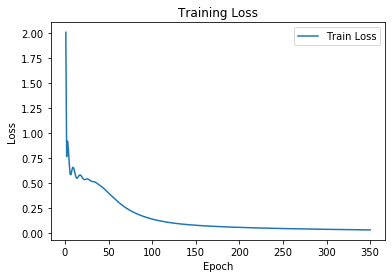

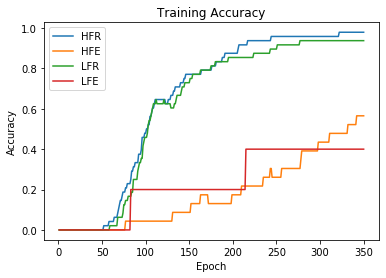

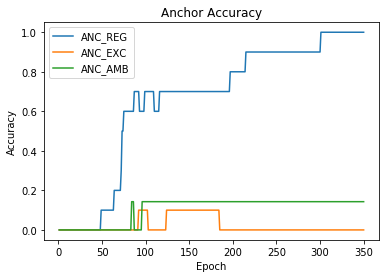

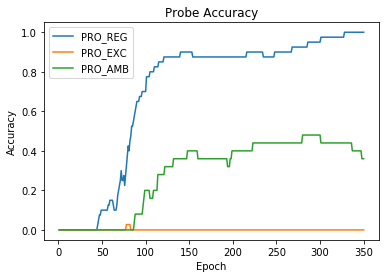

[EPOCH 351] loss: 0.027890
[EPOCH 352] loss: 0.027789
[EPOCH 353] loss: 0.027688
[EPOCH 354] loss: 0.027588
[EPOCH 355] loss: 0.027488
[EPOCH 356] loss: 0.027389
[EPOCH 357] loss: 0.027291
[EPOCH 358] loss: 0.027193
[EPOCH 359] loss: 0.027096
[EPOCH 360] loss: 0.026999
[EPOCH 361] loss: 0.026902
[EPOCH 362] loss: 0.026806
[EPOCH 363] loss: 0.026711
[EPOCH 364] loss: 0.026616
[EPOCH 365] loss: 0.026522
[EPOCH 366] loss: 0.026428
[EPOCH 367] loss: 0.026335
[EPOCH 368] loss: 0.026242
[EPOCH 369] loss: 0.026149
[EPOCH 370] loss: 0.026057
[EPOCH 371] loss: 0.025966
[EPOCH 372] loss: 0.025875
[EPOCH 373] loss: 0.025784
[EPOCH 374] loss: 0.025694
[EPOCH 375] loss: 0.025605
[EPOCH 376] loss: 0.025516
[EPOCH 377] loss: 0.025427
[EPOCH 378] loss: 0.025339
[EPOCH 379] loss: 0.025251
[EPOCH 380] loss: 0.025164
[EPOCH 381] loss: 0.025077
[EPOCH 382] loss: 0.024991
[EPOCH 383] loss: 0.024905
[EPOCH 384] loss: 0.024819
[EPOCH 385] loss: 0.024734
[EPOCH 386] loss: 0.024650
[EPOCH 387] loss: 0.024565
[

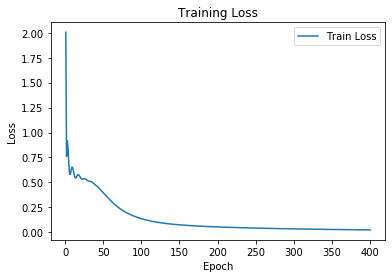

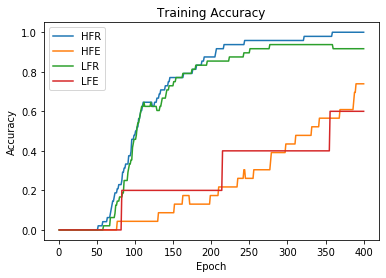

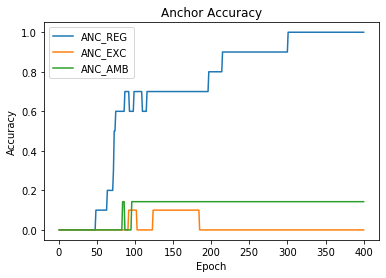

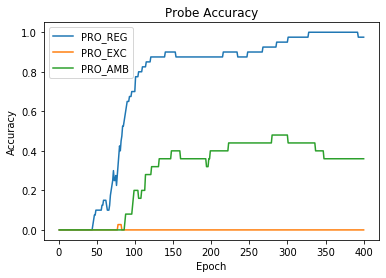

[EPOCH 401] loss: 0.023429
[EPOCH 402] loss: 0.023351
[EPOCH 403] loss: 0.023273
[EPOCH 404] loss: 0.023196
[EPOCH 405] loss: 0.023119
[EPOCH 406] loss: 0.023042
[EPOCH 407] loss: 0.022966
[EPOCH 408] loss: 0.022889
[EPOCH 409] loss: 0.022814
[EPOCH 410] loss: 0.022738
[EPOCH 411] loss: 0.022663
[EPOCH 412] loss: 0.022589
[EPOCH 413] loss: 0.022514
[EPOCH 414] loss: 0.022440
[EPOCH 415] loss: 0.022367
[EPOCH 416] loss: 0.022293
[EPOCH 417] loss: 0.022220
[EPOCH 418] loss: 0.022147
[EPOCH 419] loss: 0.022075
[EPOCH 420] loss: 0.022003
[EPOCH 421] loss: 0.021931
[EPOCH 422] loss: 0.021860
[EPOCH 423] loss: 0.021789
[EPOCH 424] loss: 0.021718
[EPOCH 425] loss: 0.021647
[EPOCH 426] loss: 0.021577
[EPOCH 427] loss: 0.021507
[EPOCH 428] loss: 0.021438
[EPOCH 429] loss: 0.021368
[EPOCH 430] loss: 0.021299
[EPOCH 431] loss: 0.021230
[EPOCH 432] loss: 0.021162
[EPOCH 433] loss: 0.021094
[EPOCH 434] loss: 0.021026
[EPOCH 435] loss: 0.020958
[EPOCH 436] loss: 0.020891
[EPOCH 437] loss: 0.020824
[

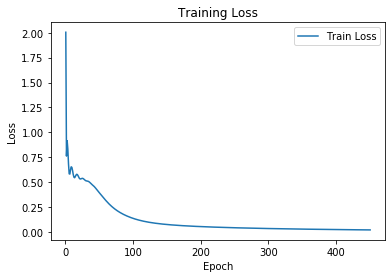

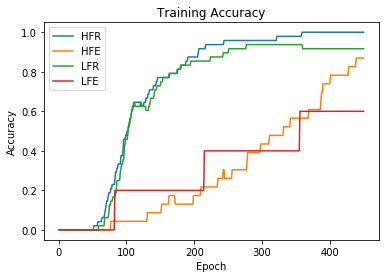

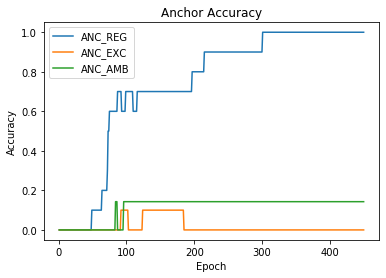

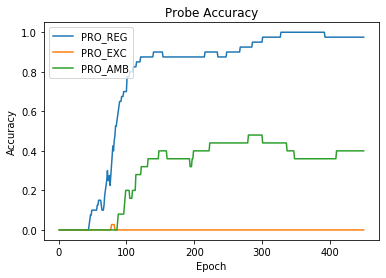

[EPOCH 451] loss: 0.019916
[EPOCH 452] loss: 0.019853
[EPOCH 453] loss: 0.019790
[EPOCH 454] loss: 0.019728
[EPOCH 455] loss: 0.019666
[EPOCH 456] loss: 0.019604
[EPOCH 457] loss: 0.019543
[EPOCH 458] loss: 0.019481
[EPOCH 459] loss: 0.019420
[EPOCH 460] loss: 0.019359
[EPOCH 461] loss: 0.019299
[EPOCH 462] loss: 0.019238
[EPOCH 463] loss: 0.019178
[EPOCH 464] loss: 0.019118
[EPOCH 465] loss: 0.019059
[EPOCH 466] loss: 0.018999
[EPOCH 467] loss: 0.018940
[EPOCH 468] loss: 0.018881
[EPOCH 469] loss: 0.018822
[EPOCH 470] loss: 0.018764
[EPOCH 471] loss: 0.018706
[EPOCH 472] loss: 0.018647
[EPOCH 473] loss: 0.018589
[EPOCH 474] loss: 0.018532
[EPOCH 475] loss: 0.018474
[EPOCH 476] loss: 0.018417
[EPOCH 477] loss: 0.018360
[EPOCH 478] loss: 0.018303
[EPOCH 479] loss: 0.018246
[EPOCH 480] loss: 0.018190
[EPOCH 481] loss: 0.018133
[EPOCH 482] loss: 0.018077
[EPOCH 483] loss: 0.018021
[EPOCH 484] loss: 0.017965
[EPOCH 485] loss: 0.017910
[EPOCH 486] loss: 0.017854
[EPOCH 487] loss: 0.017799
[

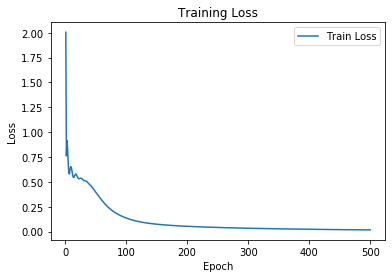

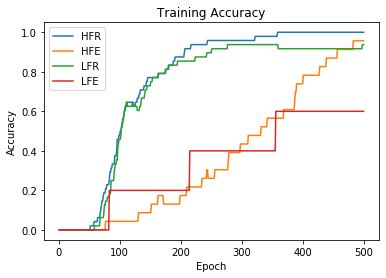

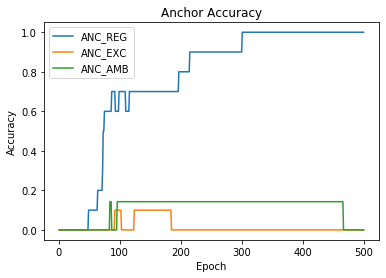

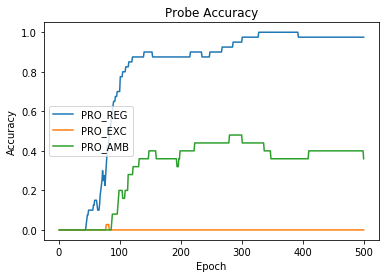

[EPOCH 501] loss: 0.007078
[EPOCH 502] loss: 0.007042
[EPOCH 503] loss: 0.006987
[EPOCH 504] loss: 0.006917
[EPOCH 505] loss: 0.006838
[EPOCH 506] loss: 0.006751
[EPOCH 507] loss: 0.006663
[EPOCH 508] loss: 0.006575
[EPOCH 509] loss: 0.006491
[EPOCH 510] loss: 0.006411
[EPOCH 511] loss: 0.006337
[EPOCH 512] loss: 0.006268
[EPOCH 513] loss: 0.006206
[EPOCH 514] loss: 0.006150
[EPOCH 515] loss: 0.006099
[EPOCH 516] loss: 0.006051
[EPOCH 517] loss: 0.006006
[EPOCH 518] loss: 0.005962
[EPOCH 519] loss: 0.005920
[EPOCH 520] loss: 0.005881
[EPOCH 521] loss: 0.005843
[EPOCH 522] loss: 0.005809
[EPOCH 523] loss: 0.005776
[EPOCH 524] loss: 0.005746
[EPOCH 525] loss: 0.005717
[EPOCH 526] loss: 0.005689
[EPOCH 527] loss: 0.005662
[EPOCH 528] loss: 0.005636
[EPOCH 529] loss: 0.005611
[EPOCH 530] loss: 0.005587
[EPOCH 531] loss: 0.005564
[EPOCH 532] loss: 0.005542
[EPOCH 533] loss: 0.005521
[EPOCH 534] loss: 0.005500
[EPOCH 535] loss: 0.005481
[EPOCH 536] loss: 0.005462
[EPOCH 537] loss: 0.005444
[

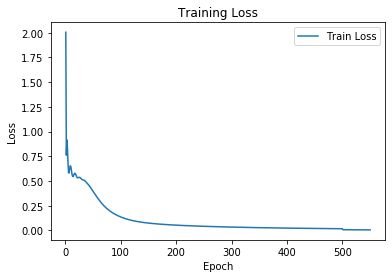

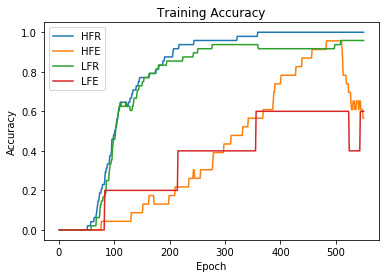

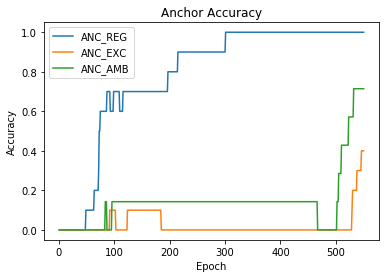

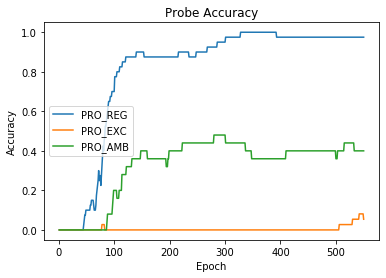

[EPOCH 551] loss: 0.005245
[EPOCH 552] loss: 0.005233
[EPOCH 553] loss: 0.005222
[EPOCH 554] loss: 0.005211
[EPOCH 555] loss: 0.005200
[EPOCH 556] loss: 0.005189
[EPOCH 557] loss: 0.005179
[EPOCH 558] loss: 0.005169
[EPOCH 559] loss: 0.005158
[EPOCH 560] loss: 0.005148
[EPOCH 561] loss: 0.005139
[EPOCH 562] loss: 0.005129
[EPOCH 563] loss: 0.005120
[EPOCH 564] loss: 0.005110
[EPOCH 565] loss: 0.005101
[EPOCH 566] loss: 0.005092
[EPOCH 567] loss: 0.005083
[EPOCH 568] loss: 0.005074
[EPOCH 569] loss: 0.005065
[EPOCH 570] loss: 0.005056
[EPOCH 571] loss: 0.005048
[EPOCH 572] loss: 0.005039
[EPOCH 573] loss: 0.005031
[EPOCH 574] loss: 0.005023
[EPOCH 575] loss: 0.005015
[EPOCH 576] loss: 0.005007
[EPOCH 577] loss: 0.004999
[EPOCH 578] loss: 0.004991
[EPOCH 579] loss: 0.004983
[EPOCH 580] loss: 0.004975
[EPOCH 581] loss: 0.004967
[EPOCH 582] loss: 0.004960
[EPOCH 583] loss: 0.004952
[EPOCH 584] loss: 0.004945
[EPOCH 585] loss: 0.004937
[EPOCH 586] loss: 0.004930
[EPOCH 587] loss: 0.004922
[

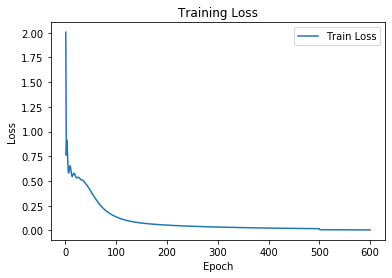

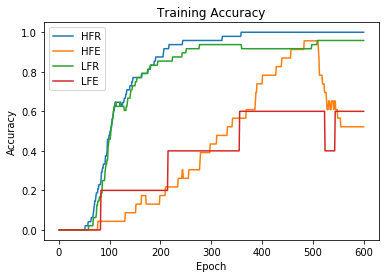

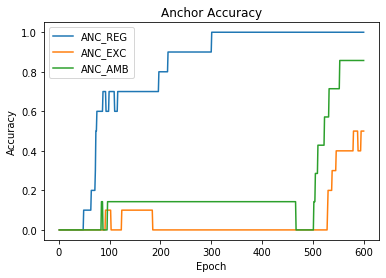

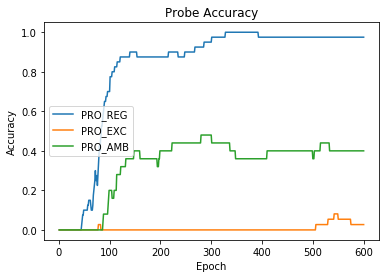

FileNotFoundError: [Errno 2] No such file or directory: '../test//Users/BrianLam/UTSC Research/Plaut_Model/results/jan01_test01/lossplot_final.png'

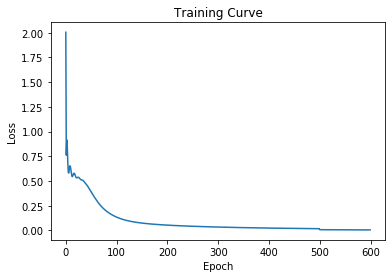

In [20]:
# create a new folder for every run
path = Path(os.getcwd()).parent #get parent (Plaut_Model) directory filepath
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = str(path)+"/results/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1


print("Test Results saved in :", rootdir)

torch.manual_seed(1) # initialize random seed
model = plaut_net() # initialize model
train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, rootdir, lr=0.1) # train!!!!

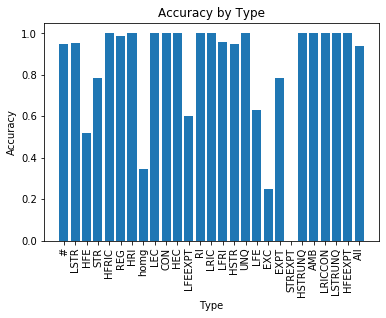

In [7]:
# obtain list of categories in dataset, and add "All" for overall accuracy
types = list(plaut_ds.df["type"].unique())
types.append("All")
    
accuracy = get_accuracy(model, plaut_loader, types)


# plot in bar graph
plt.bar(types, accuracy)
plt.xticks(rotation='vertical')
plt.xlabel("Type")
plt.ylabel("Accuracy")
plt.title("Accuracy by Type")
plt.savefig("../test/"+rootdir+"/accuracy_chart_final.png", dpi=150)
plt.show()


In [8]:
# function to get the accuracy of a particular category
def get_accuracy2 (model, train_loader, cat='All'):
    correct = 0
    total = 0
    for i, data in enumerate (train_loader): # get batch from dataloader
        # extract inputs, labels, type from batch
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        types = pd.DataFrame(data["type"])
        
        outputs = model(inputs) # find prediction using model
        outputs = outputs.round() # round output to 0 or 1
        compare = torch.eq(outputs, labels).sum(dim=1) # compare with labels
        
        if cat == 'All':
            correct += torch.eq(compare, 61).sum().item() # count as correct if all 61 elements match label
            total += len(compare)
        else:
            types = types.apply(lambda x: x == cat) # check for desired type
            compare = pd.DataFrame(compare)
            correct += ((types == True) & (compare == 61)).sum()[0] # count as correct if desired type AND all 61 elements match total
            total += (types==True).sum()[0] # count all of the desired type
    
    return correct/(total) # return accuracy

In [9]:
def get_accuracy_vowels (model, train_loader, cat=['REG', 'EXC', 'AMB']):
    correct = [0, 0, 0]
    total = [0, 0, 0]
    for i, data in enumerate (train_loader):
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        labels = labels[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        
        outputs = model(inputs)
        outputs = outputs[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        outputs = torch.sigmoid(outputs).round()
        compare = torch.eq(outputs, labels).sum(dim=1)
        for i in range(len(cat)):
            types = pd.DataFrame(data["type"])
            #print(types)
            types = types.apply(lambda x: x == cat[i])
            #print(types)
            #break
            compare = pd.DataFrame(compare)
            correct[i] += ((types == True) & (compare == len(phoneme_vowel))).sum()[0]
            total[i] += (types==True).sum()[0]
    return correct, total